In [691]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
import numpy as np
import math
from statsmodels.tsa.stattools import adfuller

## 1. Time Series Prep

In [692]:
# Load risk free rate data
eff_rate = pd.read_excel('effr.xlsx',index_col=None)

c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [693]:
# Choose the date and rate column
eff_rate = eff_rate[['Effective Date','Rate (%)']]

In [694]:
# Turn year rate into daily rate
eff_rate['Rate (%)'] = eff_rate['Rate (%)'].apply(lambda x: x/252)

In [695]:
# Reindex
eff_rate = eff_rate.set_index('Effective Date')

In [696]:
eff_rate.index.names = ['Date']
eff_rate = eff_rate.iloc[::-1]

In [697]:
eff_rate.index = pd.to_datetime(eff_rate.index)

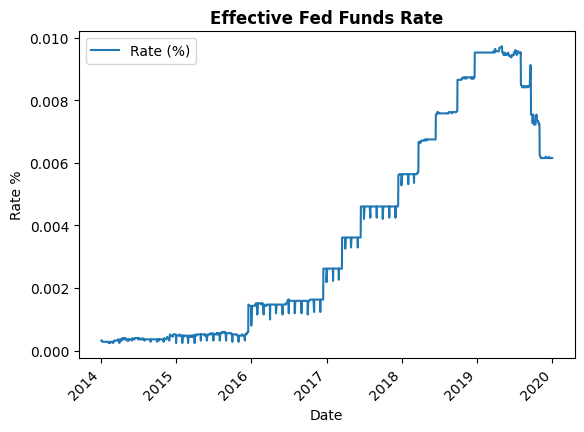

In [698]:
eff_rate.plot()
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Rate %')
plt.title('Effective Fed Funds Rate',fontsize='large',fontweight='bold')
plt.show()

In [699]:
# Download S&P 500 ETF
snp500_ETF = yf.download(tickers='SPY',start='2014-01-01',end='2019-12-31')

[*********************100%***********************]  1 of 1 completed


In [700]:
# Choose the close value
snp500_ETF = snp500_ETF['Close']

In [701]:
snp500_ETF = snp500_ETF.to_frame()

In [703]:
assets = pd.merge(snp500_ETF,eff_rate,how='left',left_index=True,right_index=True)
assets = assets.fillna(method='ffill')

In [704]:
assets['Return'] = snp500_ETF['Close'].shift(-1)/snp500_ETF['Close']-1

In [705]:
snp500_ETF_return = assets['Return']

In [706]:
snp500_ETF_return = snp500_ETF_return.to_frame()

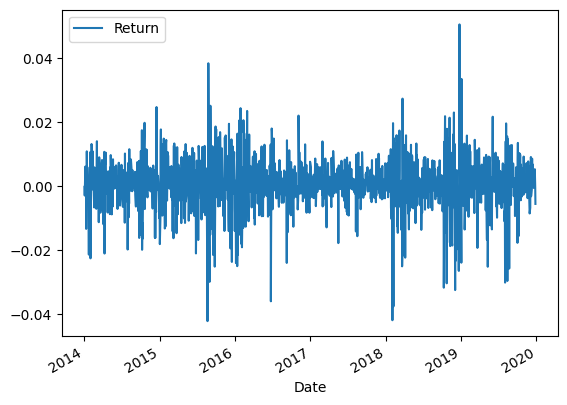

In [707]:
snp500_ETF_return.plot()
plt.show()

In [708]:
assets['Excess return'] = assets['Return'] - assets['Rate (%)']/100

In [17]:
#assets['Excess return'] = snp500_ETF_return['Return'].sub(eff_rate['Rate (%)'].apply(lambda x: x/100),axis=0)

In [709]:
snp500_ETF_excessreturn = assets['Excess return'].dropna()

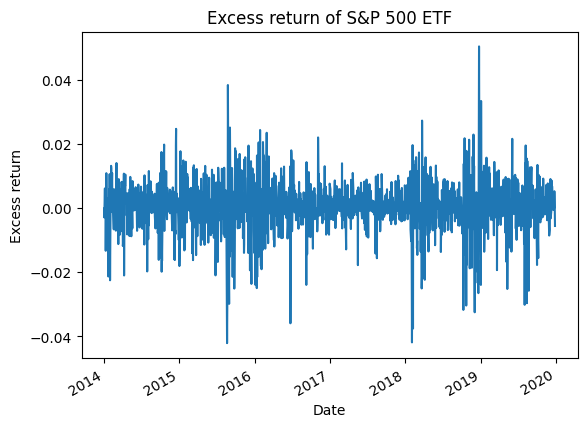

In [710]:
snp500_ETF_excessreturn.plot()
plt.xlabel('Date')
plt.ylabel('Excess return')
plt.title('Excess return of S&P 500 ETF')
plt.show()

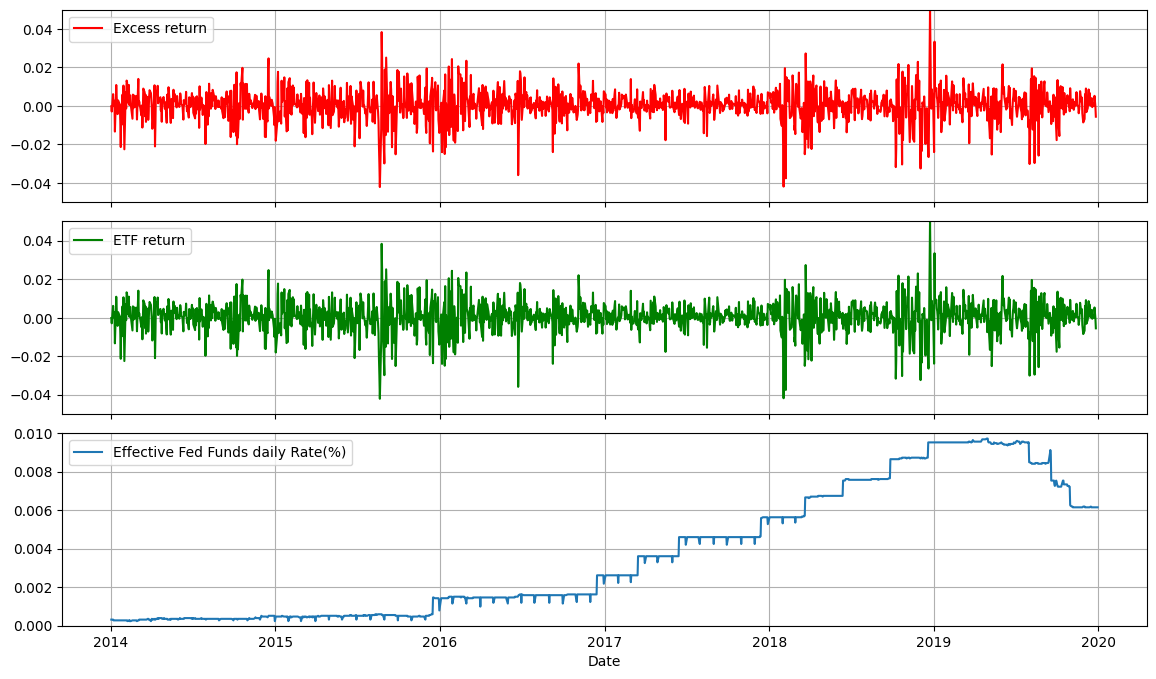

In [711]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(14, 8))

ax0 = plt.subplot(3, 1, 1)
ax0.plot(snp500_ETF_excessreturn,'r-',label='Excess return')
ax0.set_ylim(-0.05, 0.05)
ax0.legend(loc='upper left')
ax0.grid(True)

ax1 = plt.subplot(3, 1, 2)
ax1.plot(snp500_ETF_return,'g-',label='ETF return')
ax1.set_ylim(-0.05, 0.05)
ax1.legend(loc='upper left')
ax1.grid(True)

ax2 = plt.subplot(3, 1, 3)
ax2.plot(eff_rate,label='Effective Fed Funds daily Rate(%)')
ax2.set_ylim(0, 0.01)
ax2.legend(loc='upper left')
ax2.grid(True)

ax2.set_xlabel('Date')
plt.subplots_adjust(wspace=0, hspace=0.1)
#savefig
plt.savefig('Excess return of S&P 500 ETF.png',dpi=600)
plt.show()


Preprocess on close price to see if the first order difference close price is stationary

In [1282]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
adf_test(assets['Close'][:400].diff(1).dropna().diff(1).dropna())

Results of Dickey-Fuller Test:
Test Statistic                -9.314942e+00
p-value                        1.025149e-15
#Lags Used                     1.500000e+01
Number of Observations Used    3.820000e+02
Critical Value (1%)           -3.447585e+00
Critical Value (5%)           -2.869136e+00
Critical Value (10%)          -2.570816e+00
dtype: float64


In [22]:
print("Results of Dickey-Fuller Test shows that the p-value is less than 0.05, so we can reject the null hypothesis that the time series is not stationary.")

Results of Dickey-Fuller Test shows that the p-value is less than 0.05, so we can reject the null hypothesis that the time series is not stationary.


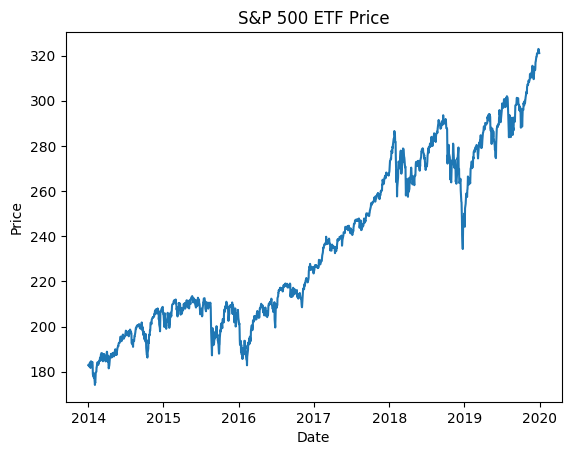

In [1593]:
plt.plot(assets['Close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('S&P 500 ETF Price')
plt.savefig('S&P 500 ETF Price.png',dpi=600)
plt.show()

## 2. Trading Strategies

Bollinger bands

In [713]:
assets = assets.fillna(method='ffill')

In [714]:
#Split samples into training and test set by 7:3
training_set = assets.iloc[:1056,:]
test_set = assets.iloc[1056:,:]

In [1686]:
test_set

Close  Rate (%)    Return  Excess return
Date                                                     
2018-03-14  275.299988  0.005635 -0.001090      -0.001146
2018-03-15  275.000000  0.005675 -0.002909      -0.002966
2018-03-16  274.200012  0.005675 -0.013530      -0.013587
2018-03-19  270.489990  0.005675  0.001701       0.001644
2018-03-20  270.950012  0.005714 -0.001919      -0.001976
...                ...       ...       ...            ...
2019-12-23  321.220001  0.006151  0.000031      -0.000030
2019-12-24  321.230011  0.006151  0.005323       0.005262
2019-12-26  322.940002  0.006151 -0.000248      -0.000309
2019-12-27  322.859985  0.006151 -0.005513      -0.005575
2019-12-30  321.079987  0.006151 -0.005513      -0.005575

[453 rows x 4 columns]

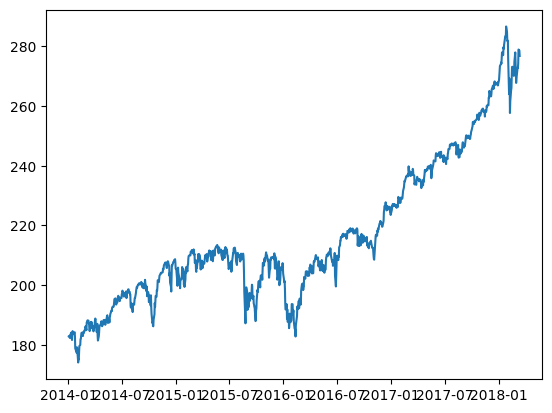

In [1595]:
plt.plot(training_set['Close'])

## Buy and Hold

In [1288]:
V0 = 200000
L = 5
#set data1 as a copy of training_set
data1 = training_set.copy()
#data1 = assets.copy()
#initialize the columns
data1['PnL'] = np.zeros(len(data1))
data1['capital profit'] = np.zeros(len(data1))
data1['position'] = np.zeros(len(data1))
data1['cash'] = np.zeros(len(data1))
data1['Theta'] = np.zeros(len(data1))
data1['V'] = np.zeros(len(data1))
data1['cash'][0] = V0
data1['V'][0] = V0

for i in range(len(data1)):
    if i == 0:
        data1['position'][i] = math.floor(L * data1['cash'][i] * 0.65 / data1['Close'][i])
        data1['cash'][i] = V0 - data1['position'][i] * data1['Close'][i]/L
        data1['capital profit'][i] = data1['Rate (%)'][i] * 0.01 * data1['cash'][i]
        data1['PnL'][i] = data1['position'][i] *data1['Close'][i] * data1['Excess return'][i] + data1['capital profit'][i]
        data1['cash'][i] = data1['cash'][i] + data1['PnL'][i]
        data1['V'][i] = data1['V'][0] + data1['PnL'][0]
    elif i == len(data1)-1:
        data1['position'][i] = 0
        data1['cash'][i] = data1['cash'][i-1] + data1['position'][i-1] * data1['Close'][0]/L
        data1['capital profit'][i] = data1['Rate (%)'][i] * 0.01 * data1['cash'][i]
        data1['PnL'][i] = data1['capital profit'][i]
        data1['cash'][i] = data1['cash'][i] + data1['PnL'][i]
        data1['V'][i] = data1['V'][i-1] + data1['PnL'][i]
    else:
        data1['position'][i] = data1['position'][i-1]
        data1['capital profit'][i] = data1['Rate (%)'][i] * 0.01 * data1['cash'][i-1]
        data1['PnL'][i] = data1['position'][i] *data1['Close'][i]* data1['Excess return'][i] + data1['capital profit'][i]
        data1['cash'][i] = data1['cash'][i-1] + data1['PnL'][i]
        data1['V'][i] = data1['V'][i-1] + data1['PnL'][i]
    
    data1['Theta'][i] = data1['position'][i]* data1['Close'][i]

data1_train = data1.copy()

In [1289]:
V0 = 200000
L = 5
#set data1 as a copy of training_set
data1 = test_set.copy()
#data1 = assets.copy()
#initialize the columns
data1['PnL'] = np.zeros(len(data1))
data1['capital profit'] = np.zeros(len(data1))
data1['position'] = np.zeros(len(data1))
data1['cash'] = np.zeros(len(data1))
data1['Theta'] = np.zeros(len(data1))
data1['V'] = np.zeros(len(data1))
data1['cash'][0] = V0
data1['V'][0] = V0

for i in range(len(data1)):
    if i == 0:
        data1['position'][i] = math.floor(L * data1['cash'][i] * 0.65 / data1['Close'][i])
        data1['cash'][i] = V0 - data1['position'][i] * data1['Close'][i]/L
        data1['capital profit'][i] = data1['Rate (%)'][i] * 0.01 * data1['cash'][i]
        data1['PnL'][i] = data1['position'][i] *data1['Close'][i] * data1['Excess return'][i] + data1['capital profit'][i]
        data1['cash'][i] = data1['cash'][i] + data1['PnL'][i]
        data1['V'][i] = data1['V'][0] + data1['PnL'][0]
    elif i == len(data1)-1:
        data1['position'][i] = 0
        data1['cash'][i] = data1['cash'][i-1] + data1['position'][i-1] * data1['Close'][0]/L
        data1['capital profit'][i] = data1['Rate (%)'][i] * 0.01 * data1['cash'][i]
        data1['PnL'][i] = data1['capital profit'][i]
        data1['cash'][i] = data1['cash'][i] + data1['PnL'][i]
        data1['V'][i] = data1['V'][i-1] + data1['PnL'][i]
    else:
        data1['position'][i] = data1['position'][i-1]
        data1['capital profit'][i] = data1['Rate (%)'][i] * 0.01 * data1['cash'][i-1]
        data1['PnL'][i] = data1['position'][i] *data1['Close'][i]* data1['Excess return'][i] + data1['capital profit'][i]
        data1['cash'][i] = data1['cash'][i-1] + data1['PnL'][i]
        data1['V'][i] = data1['V'][i-1] + data1['PnL'][i]
    
    data1['Theta'][i] = data1['position'][i]* data1['Close'][i]

data1_test = data1.copy()

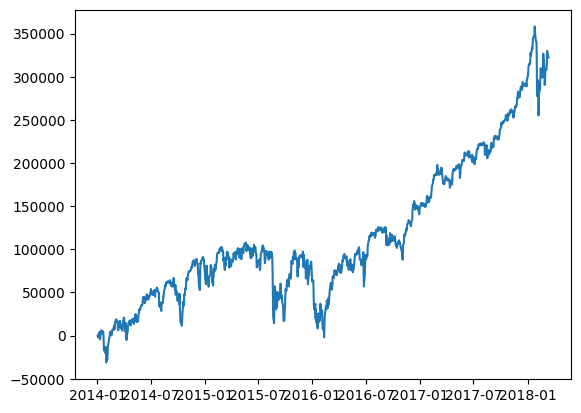

In [1290]:
plt.plot(data1_train['PnL'].cumsum(), label = 'PnL')

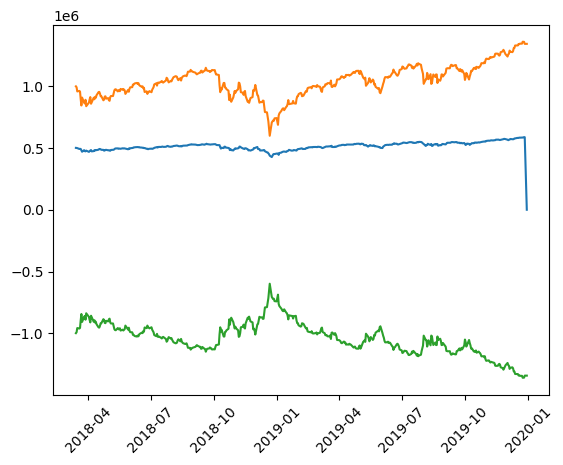

In [866]:
plt.plot(data1['Theta'])
plt.plot(data1['V']*L)
plt.plot(-data1['V']*L)
plt.xticks(rotation=45)
plt.show()

In [867]:
turn_over_dollar1 = data1['Theta'].diff().abs().sum()
print('turnover dollars for buy and hold is $%d' % turn_over_dollar1)
turn_over_units1 = (data1['Theta']/data1['Close']).diff().abs().sum()
print('turnover units for buy and hold is %d' % turn_over_units1)

turnover dollars for buy and hold is $2040166
turnover units for buy and hold is 1816


## Long short Bollinger bands strategy

In [1583]:
# Retrieve the data for the SPDR
data = training_set.copy()


# Compute the 20-day moving average
data['MA20'] = data['Close'].rolling(window=15).mean()

# Compute the 20-day standard deviation
data['STD20'] = data['Close'].rolling(window=15).std()

# Compute the upper and lower Bollinger Bands
data['UpperBand'] = data['MA20'] + 2 * data['STD20']
data['LowerBand'] = data['MA20'] - 2 * data['STD20']

# use bollinger bands to determine the signal long at buy signal and short at sell signal
data['Signal'] = 0.0
data['Signal'] = np.where(data['Close'] > data['UpperBand'], -1.0, 0.0)
data['Signal'] = np.where(data['Close'] < data['LowerBand'], 1.0, data['Signal'])

V0 = 200000
L = 5
#innitialize the dataframe
data['capital profit'] = np.zeros(len(data))
data['capital profit'][0] = V0 * data['Rate (%)'][0] * 0.01
data['PnL'] = np.zeros(len(data))
data['PnL'][0] = data['capital profit'][0]
data['position'] = np.zeros(len(data))
data['cash'] = np.zeros(len(data))
data['Theta'] = np.zeros(len(data))
data['cash'][0] = V0 + data['capital profit'][0]
data['V'] = np.zeros(len(data))
data['V'][0] = V0

sell_entry = 0
buy_entry = 0

for i in range(1,299):
    data['position'][i] = 0
    data['cash'][i] = data['cash'][i-1]
    data['capital profit'][i] = data['cash'][i] * data['Rate (%)'][i] * 0.01
    data['PnL'][i] = data['capital profit'][i]
    data['cash'][i] = data['cash'][i] + data['PnL'][i]
    data['Theta'][i] = data['position'][i]* data['Close'][i]
    data['V'][i] = data['V'][i-1] + data['PnL'][i]


for i in range(299, len(data)):
    #exit the position
    if data['Signal'][i] == 1 and buy_entry == 0 and data['position'][i-1] >= 0:
        buy_entry = data['Close'][i]
        buy_date = i
        data['position'][i] = math.floor((L * data['cash'][i-1] * 0.65) / data['Close'][i])
        data['cash'][i] = data['cash'][i-1] - data['position'][i] * data['Close'][i]/L
        data['capital profit'][i] = data['Rate (%)'][i] * 0.01 * data['cash'][i]
        data['PnL'][i] = data['position'][i] *data['Close'][i] * data['Excess return'][i] + data['capital profit'][i]
        data['cash'][i] = data['cash'][i] + data['PnL'][i]


    elif data['Signal'][i] == -1 and sell_entry == 0 and data['position'][i-1] <= 0:
        sell_entry = data['Close'][i]
        sell_date = i
        data['position'][i] = - math.floor((L * data['cash'][i-1] * 0.65) / data['Close'][i])
        data['cash'][i] = data['cash'][i-1] - abs(data['position'][i]) * data['Close'][i]/L
        data['capital profit'][i] = data['Rate (%)'][i] * 0.01 * data['cash'][i]
        data['PnL'][i] = data['position'][i] *data['Close'][i] * data['Excess return'][i] + data['capital profit'][i]
        data['cash'][i] = data['cash'][i] + data['PnL'][i]

    
    elif buy_entry != 0 and data['Close'][i] > data['MA20'][i]  + 0.5*data['STD20'][i]:
        data['position'][i] = 0
        data['cash'][i] = data['cash'][i-1] + abs(data['position'][i-1]) * buy_entry/L
        #data['cash'][i] = data['cash'][i-1] + abs(data['position'][i-1]) * data['Close'][i]/L
        data['capital profit'][i] = data['Rate (%)'][i] * 0.01 * data['cash'][i]
        data['PnL'][i] = data['capital profit'][i]
        data['cash'][i] = data['cash'][i] + data['PnL'][i]
        buy_entry = 0

        
    elif sell_entry != 0 and data['Close'][i] < data['MA20'][i] - 0.5*data['STD20'][i]:
        data['position'][i] = 0
        data['cash'][i] = data['cash'][i-1] + abs(data['position'][i-1]) * sell_entry/L
        #data['cash'][i] = data['cash'][i-1] + abs(data['position'][i-1]) * data['Close'][i]/L
        data['capital profit'][i] = data['Rate (%)'][i] * 0.01 * data['cash'][i]
        data['PnL'][i] = data['capital profit'][i]
        data['cash'][i] = data['cash'][i] + data['PnL'][i]
        sell_entry = 0

    elif buy_entry != 0 and data['PnL'][buy_date:i].sum() < data['Theta'][buy_date] * -0.05:
            data['position'][i] = 0
            data['cash'][i] = data['cash'][i-1] + abs(data['position'][i-1]) * buy_entry/L
            buy_entry = 0
            buy_date = -1
            data['capital profit'][i] = data['Rate (%)'][i] * 0.01 * data['cash'][i]
            data['PnL'][i] = data['capital profit'][i]
            data['cash'][i] = data['cash'][i] + data['PnL'][i]

    
    elif sell_entry != 0 and data['PnL'][sell_date:i].sum() < abs(data['Theta'][sell_date]) * -0.05:
            data['position'][i] = 0
            data['cash'][i] = data['cash'][i-1] + abs(data['position'][i-1]) * sell_entry/L
            sell_entry = 0
            sell_date = -1
            data['capital profit'][i] = data['Rate (%)'][i] * 0.01 * data['cash'][i]
            data['PnL'][i] = data['capital profit'][i]
            data['cash'][i] = data['cash'][i] + data['PnL'][i]
    

    else:
        data['position'][i] = data['position'][i-1]
        data['cash'][i] = data['cash'][i-1]
        data['capital profit'][i] = data['Rate (%)'][i] * 0.01 * data['cash'][i]
        data['PnL'][i] = data['capital profit'][i] + data['position'][i] *data['Close'][i] * data['Excess return'][i]
        data['cash'][i] = data['cash'][i] + data['PnL'][i]


    if i == len(data)-1:
        if buy_entry != 0:
            data['position'][i] = 0
            data['cash'][i] = data['cash'][i-1] + abs(data['position'][i-1]) * buy_entry/L
            data['capital profit'][i] = data['Rate (%)'][i] * 0.01 * data['cash'][i]
            data['PnL'][i] = data['capital profit'][i]
            data['cash'][i] = data['cash'][i] + data['PnL'][i]
        if sell_entry != 0:
            data['position'][i] = 0
            data['cash'][i] = data['cash'][i-1] + abs(data['position'][i-1]) * sell_entry/L
            data['capital profit'][i] = data['Rate (%)'][i] * 0.01 * data['cash'][i]
            data['PnL'][i] = data['capital profit'][i]
            data['cash'][i] = data['cash'][i] + data['PnL'][i]
    
    data['Theta'][i] = data['position'][i]* data['Close'][i]
    data['V'][i] = data['V'][i-1] + data['PnL'][i]

data_train = data.copy()

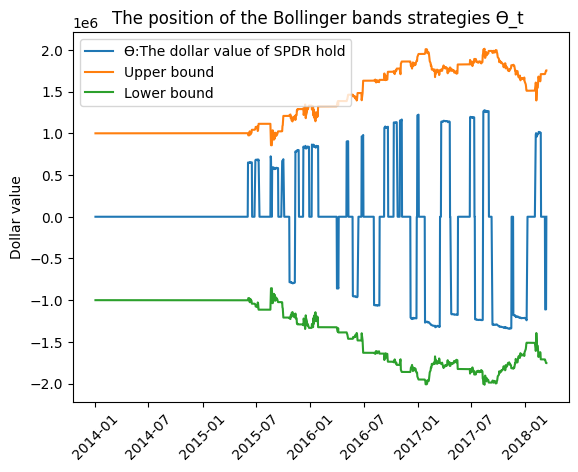

In [1584]:
#data['Theta'] = data['position'].mul(data['Close']) 
plt.plot(data_train['Theta'])
plt.plot(data_train['V']*L)
plt.plot(-data_train['V']*L)
plt.xticks(rotation=45)
plt.legend(['\u03F4:The dollar value of SPDR hold','Upper bound','Lower bound'], loc='upper left')
plt.title('The position of the Bollinger bands strategies \u03F4_t ')
plt.ylabel('Dollar value')
plt.show()

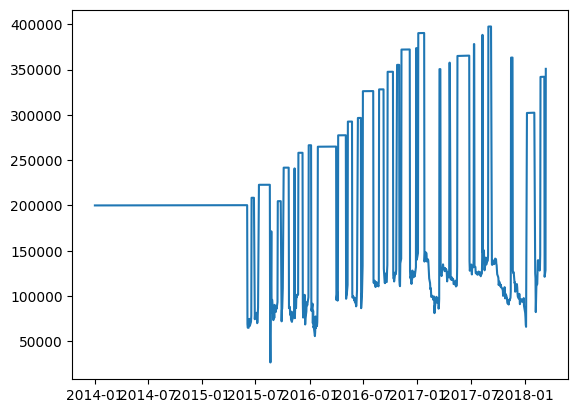

In [1587]:
plt.plot(data_train['cash'])

In [1373]:
# Retrieve the data for the SPDR
data = test_set.copy()


# Compute the 20-day moving average
data['MA20'] = data['Close'].rolling(window=15).mean()

# Compute the 20-day standard deviation
data['STD20'] = data['Close'].rolling(window=15).std()

# Compute the upper and lower Bollinger Bands
data['UpperBand'] = data['MA20'] + 2 * data['STD20']
data['LowerBand'] = data['MA20'] - 2 * data['STD20']

# use bollinger bands to determine the signal long at buy signal and short at sell signal
data['Signal'] = 0.0
data['Signal'] = np.where(data['Close'] > data['UpperBand'], -1.0, 0.0)
data['Signal'] = np.where(data['Close'] < data['LowerBand'], 1.0, data['Signal'])

V0 = 200000
L = 5
#innitialize the dataframe
data['capital profit'] = np.zeros(len(data))
data['capital profit'][0] = V0 * data['Rate (%)'][0] * 0.01
data['PnL'] = np.zeros(len(data))
data['PnL'][0] = data['capital profit'][0]
data['position'] = np.zeros(len(data))
data['cash'] = np.zeros(len(data))
data['Theta'] = np.zeros(len(data))
data['cash'][0] = V0 + data['capital profit'][0]
data['V'] = np.zeros(len(data))
data['V'][0] = V0

sell_entry = 0
buy_entry = 0

for i in range(1,19):
    data['position'][i] = 0
    data['cash'][i] = data['cash'][i-1]
    data['capital profit'][i] = data['cash'][i] * data['Rate (%)'][i] * 0.01
    data['PnL'][i] = data['capital profit'][i]
    data['cash'][i] = data['cash'][i] + data['PnL'][i]
    data['Theta'][i] = data['position'][i]* data['Close'][i]
    data['V'][i] = data['V'][i-1] + data['PnL'][i]


for i in range(19, len(data)):
    #exit the position
    if data['Signal'][i] == 1 and buy_entry == 0 and data['position'][i-1] >= 0:
        buy_entry = data['Close'][i]
        buy_date = i
        data['position'][i] = math.floor((L * data['cash'][i-1] * 0.65) / data['Close'][i])
        data['cash'][i] = data['cash'][i-1] - data['position'][i] * data['Close'][i]/L
        data['capital profit'][i] = data['Rate (%)'][i] * 0.01 * data['cash'][i]
        data['PnL'][i] = data['position'][i] *data['Close'][i] * data['Excess return'][i] + data['capital profit'][i]
        data['cash'][i] = data['cash'][i] + data['PnL'][i]


    elif data['Signal'][i] == -1 and sell_entry == 0 and data['position'][i-1] <= 0:
        sell_entry = data['Close'][i]
        sell_date = i
        data['position'][i] = - math.floor((L * data['cash'][i-1] * 0.65) / data['Close'][i])
        data['cash'][i] = data['cash'][i-1] - abs(data['position'][i]) * data['Close'][i]/L
        data['capital profit'][i] = data['Rate (%)'][i] * 0.01 * data['cash'][i]
        data['PnL'][i] = data['position'][i] *data['Close'][i] * data['Excess return'][i] + data['capital profit'][i]
        data['cash'][i] = data['cash'][i] + data['PnL'][i]

    
    elif buy_entry != 0 and data['Close'][i] > data['MA20'][i]  + 0.7*data['STD20'][i]:
        data['position'][i] = 0
        data['cash'][i] = data['cash'][i-1] + abs(data['position'][i-1]) * buy_entry/L
        #data['cash'][i] = data['cash'][i-1] + abs(data['position'][i-1]) * data['Close'][i]/L
        data['capital profit'][i] = data['Rate (%)'][i] * 0.01 * data['cash'][i]
        data['PnL'][i] = data['capital profit'][i]
        data['cash'][i] = data['cash'][i] + data['PnL'][i]
        buy_entry = 0

        
    elif sell_entry != 0 and data['Close'][i] < data['MA20'][i] - 0.7*data['STD20'][i]:
        data['position'][i] = 0
        data['cash'][i] = data['cash'][i-1] + abs(data['position'][i-1]) * sell_entry/L
        #data['cash'][i] = data['cash'][i-1] + abs(data['position'][i-1]) * data['Close'][i]/L
        data['capital profit'][i] = data['Rate (%)'][i] * 0.01 * data['cash'][i]
        data['PnL'][i] = data['capital profit'][i]
        data['cash'][i] = data['cash'][i] + data['PnL'][i]
        sell_entry = 0

    
    elif buy_entry != 0 and data['PnL'][buy_date:i].sum() < data['Theta'][buy_date] * -0.05:
            data['position'][i] = 0
            data['cash'][i] = data['cash'][i-1] + abs(data['position'][i-1]) * buy_entry/L
            buy_entry = 0
            buy_date = -1
            data['capital profit'][i] = data['Rate (%)'][i] * 0.01 * data['cash'][i]
            data['PnL'][i] = data['capital profit'][i]
            data['cash'][i] = data['cash'][i] + data['PnL'][i]

    
    elif sell_entry != 0 and data['PnL'][sell_date:i].sum() < abs(data['Theta'][sell_date]) * -0.05:
            data['position'][i] = 0
            data['cash'][i] = data['cash'][i-1] + abs(data['position'][i-1]) * sell_entry/L
            sell_entry = 0
            sell_date = -1
            data['capital profit'][i] = data['Rate (%)'][i] * 0.01 * data['cash'][i]
            data['PnL'][i] = data['capital profit'][i]
            data['cash'][i] = data['cash'][i] + data['PnL'][i]

    else:
        data['position'][i] = data['position'][i-1]
        data['cash'][i] = data['cash'][i-1]
        data['capital profit'][i] = data['Rate (%)'][i] * 0.01 * data['cash'][i]
        data['PnL'][i] = data['capital profit'][i] + data['position'][i] *data['Close'][i] * data['Excess return'][i]
        data['cash'][i] = data['cash'][i] + data['PnL'][i]


    if i == len(data)-1:
        if buy_entry != 0:
            data['position'][i] = 0
            data['cash'][i] = data['cash'][i-1] + abs(data['position'][i-1]) * buy_entry/L
            data['capital profit'][i] = data['Rate (%)'][i] * 0.01 * data['cash'][i]
            data['PnL'][i] = data['capital profit'][i]
            data['cash'][i] = data['cash'][i] + data['PnL'][i]
        if sell_entry != 0:
            data['position'][i] = 0
            data['cash'][i] = data['cash'][i-1] + abs(data['position'][i-1]) * sell_entry/L
            data['capital profit'][i] = data['Rate (%)'][i] * 0.01 * data['cash'][i]
            data['PnL'][i] = data['capital profit'][i]
            data['cash'][i] = data['cash'][i] + data['PnL'][i]
    
    data['Theta'][i] = data['position'][i]* data['Close'][i]
    data['V'][i] = data['V'][i-1] + data['PnL'][i]

data_test = data.copy()

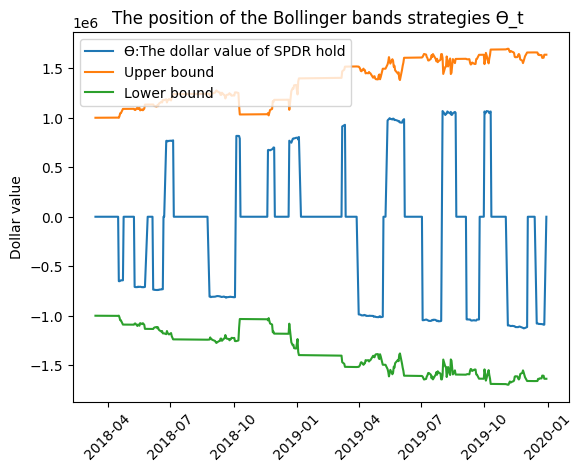

In [1374]:
#data['Theta'] = data['position'].mul(data['Close']) 
plt.plot(data_test['Theta'])
plt.plot(data_test['V']*L)
plt.plot(-data_test['V']*L)
plt.xticks(rotation=45)
plt.legend(['\u03F4:The dollar value of SPDR hold','Upper bound','Lower bound'], loc='upper left')
plt.title('The position of the Bollinger bands strategies \u03F4_t ')
plt.ylabel('Dollar value')
plt.show()

In [1375]:
data_test[400:]

Close  Rate (%)    Return  Excess return        MA20  \
Date                                                                    
2019-10-15  298.880005  0.007540 -0.001606      -0.001681  294.005998   
2019-10-16  298.399994  0.007540  0.002949       0.002874  294.057998   
2019-10-17  299.279999  0.007341 -0.004377      -0.004451  294.209998   
2019-10-18  297.970001  0.007341  0.006779       0.006706  294.381331   
2019-10-21  299.989990  0.007341 -0.003267      -0.003340  294.595998   
2019-10-22  299.010010  0.007341  0.002910       0.002836  294.980666   
2019-10-23  299.880005  0.007341  0.001634       0.001561  295.768667   
2019-10-24  300.369995  0.007341  0.004095       0.004022  296.431999   
2019-10-25  301.600006  0.007262  0.005637       0.005564  296.915332   
2019-10-28  303.299988  0.007262 -0.000297      -0.000369  297.596665   
2019-10-29  303.209991  0.007222  0.003067       0.002995  298.575332   
2019-10-30  304.140015  0.007222 -0.002663      -0.002736  299.433333   
2019-10-31  303.329987  0.006270  0.009264       0.009201  300.106000   
2019-11-01  306.140015  0.006230  0.004018       0.003955  300.763334   
2019-11-04  307.369995  0.006190 -0.001106      -0.001168  301.524666   
2019-11-05  307.029999  0.006190  0.000228       0.000166  302.067999   
2019-11-06  307.100006  0.006151  0.003517       0.003455  302.648000   
2019-11-07  308.179993  0.006151  0.002466       0.002405  303.241333   
2019-11-08  308.940002  0.006151 -0.001910      -0.001971  303.972666   
2019-11-11  308.350006  0.006151  0.002108       0.002046  304.530001   
2019-11-12  309.000000  0.006151  0.000324       0.000262  305.196000   
2019-11-13  309.100006  0.006151  0.001456       0.001394  305.810667   
2019-11-14  309.549988  0.006151  0.007236       0.007175  306.422666   
2019-11-15  311.790009  0.006151  0.000738       0.000676  307.102000   
2019-11-18  312.019989  0.006151 -0.000288      -0.000350  307.683333   
2019-11-19  311.929993  0.006151 -0.003719      -0.003780  308.264667   
2019-11-20  310.769989  0.006151 -0.001609      -0.001670  308.706665   
2019-11-21  310.269989  0.006151  0.002224       0.002162  309.169332   
2019-11-22  310.959991  0.006151  0.007750       0.007689  309.490664   
2019-11-25  313.369995  0.006151  0.002266       0.002204  309.890664   
2019-11-26  314.079987  0.006151  0.004458       0.004396  310.360663   
2019-11-27  315.480011  0.006151 -0.003709      -0.003770  310.919330   
2019-11-29  314.309998  0.006190 -0.008495      -0.008557  311.327997   
2019-12-02  311.640015  0.006190 -0.006707      -0.006768  311.507998   
2019-12-03  309.549988  0.006151  0.006170       0.006109  311.587996   
2019-12-04  311.459991  0.006151  0.001798       0.001736  311.751996   
2019-12-05  312.019989  0.006151  0.009134       0.009073  311.946661   
2019-12-06  314.869995  0.006151 -0.003144      -0.003206  312.301329   
2019-12-09  313.880005  0.006151 -0.001115      -0.001177  312.440662   
2019-12-10  313.529999  0.006151  0.002839       0.002777  312.541329   
2019-12-11  314.420013  0.006151  0.008619       0.008558  312.707330   
2019-12-12  317.130005  0.006151  0.000599       0.000538  313.131331   
2019-12-13  317.320007  0.006151  0.006870       0.006809  313.601333   
2019-12-16  319.500000  0.006190  0.000219       0.000157  314.170667   
2019-12-17  319.570007  0.006151  0.000063       0.000001  314.584001   
2019-12-18  319.589996  0.006151  0.004099       0.004037  314.951335   
2019-12-19  320.899994  0.006151 -0.000530      -0.000591  315.312667   
2019-12-20  320.730011  0.006151  0.001528       0.001466  315.740668   
2019-12-23  321.220001  0.006151  0.000031      -0.000030  316.379333   
2019-12-24  321.230011  0.006151  0.005323       0.005262  317.158002   
2019-12-26  322.940002  0.006151 -0.000248      -0.000309  317.923336   
2019-12-27  322.859985  0.006151 -0.005513      -0.005575  318.646002   
2019-12-30  321.079987  0.006151 -0.005513      -0.005575  319.060002   

 

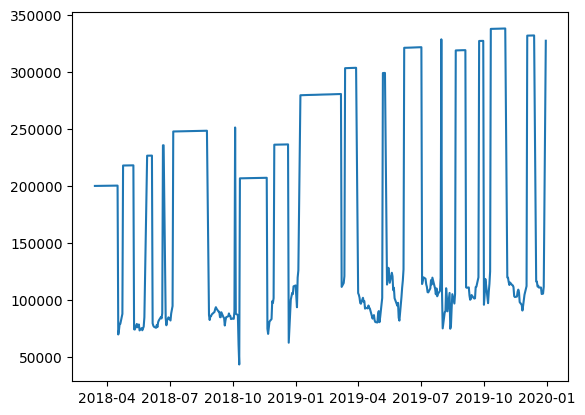

In [1376]:
plt.plot(data_test['cash'])

In [1306]:
turn_over_dollar = data_test['Theta'].diff().abs().sum()
print('turnover dollars for Bollinger bands strategy are $%d' % turn_over_dollar)
turn_over_units = data_test['position'].diff().abs().sum()
print('turnover units for buy and hold is %d' % turn_over_units)

turnover dollars for Bollinger bands strategy are $17726939
turnover units for buy and hold is 59682


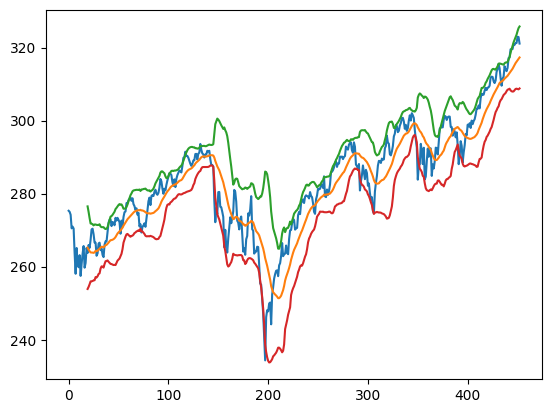

In [724]:
plt.plot(data['Close'].values)
plt.plot(data['MA20'].values)
#plt.plot(data['Close'].rolling(window=60).mean().values)
plt.plot(data['UpperBand'].values)
plt.plot(data['LowerBand'].values)

## ARIMA model

We are going to predict using etf close price, adf test shows the first difference of etf close price series is a statinary time series

In [758]:
data2 = assets.copy()
data2_train = training_set.copy()
data2_test = test_set.copy()

In [759]:
from  statsmodels.tsa.arima.model  import  ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

Find optimal parameters manually try every combination of p,q to find minimum mse in the training set

In [1298]:
#maully choose the best window size
data2_train['predict_close'] = np.zeros(len(data2_train))
sqare_error = []
window = 300
for i in range(0, len(data2_train)-1-window):
    arima_model = ARIMA(data2['Close'][:i+window+1], order=(5, 1, 2)).fit()
    data2_train['predict_close'][i+window] = arima_model.forecast(1).iloc[0]
    temp = (data2_train['predict_close'][i+window] - data2['Close'][i+1+window])**2
    sqare_error.append(temp)
mse = np.array(sqare_error).mean()
print('MSE for ARIMA model is %f' % mse)

c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

MSE for ARIMA model is 3.001453


c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\47965\AppData\Local\Temp\ipykernel_24796\3606504259.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2_train['predict_close'][i+window] = arima_model.forecast(1).iloc[0]


In [900]:
data2_test['predict_close'] = np.zeros(len(data2_test))
sqare_error = []
window = 300
for i in range(len(data2_train), len(data2)-1):
    arima_model = ARIMA(data2['Close'][:i+1], order=(5, 1, 2)).fit()
    data2_test['predict_close'][i-len(data2_train)] = arima_model.forecast(1).iloc[0]
    #temp = (data2_test['predict_close'][i-len(data2_train)] - data2['Close'][i+1])**2
    #sqare_error.append(temp)
#mse = np.array(sqare_error).mean()
#print('MSE for ARIMA model is %f' % mse)

c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index b

MSE for ARIMA model is 6.386766


c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\47965\AppData\Local\Temp\ipykernel_24796\1801706284.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2_test['predict_close'][i-len(data2_train)] = arima_model.forecast(1).iloc[0]


In [309]:
#data2_train_fit_frame = data2_train_fit.to_frame()
#data2_train_fit_frame.shift(-2)

0
Date                  
2014-01-02  182.889859
2014-01-03  182.359989
2014-01-06  183.520681
2014-01-07  183.428700
2014-01-08  183.690839
...                ...
2018-03-08  278.757037
2018-03-09  278.192330
2018-03-12  276.783174
2018-03-13         NaN
2018-03-14         NaN

[1057 rows x 1 columns]

In [310]:
#data2_train['predict_close'] = np.zeros(len(data2_train))
#for i in range (len(data2_train)):
#    data2_train['predict_close'][i] = data2_train_fit_frame.shift(-2)[0][i]

C:\Users\47965\AppData\Local\Temp\ipykernel_24796\3807999169.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2_train['predict_close'][i] = data2_train_fit_frame.shift(-2)[0][i]


In [1391]:
data2_test['signal'] = np.where((data2_test['predict_close']-data2_test['Close'])/data2_test['Close'] > 0.003 , 1, 0)
data2_test['signal'] = np.where((data2_test['predict_close']-data2_test['Close'])/data2_test['Close'] < -0.004 , -1, data2_test['signal'])

In [1294]:
data2_train['signal'] = np.where((data2_train['predict_close']-data2_train['Close'])/data2_train['Close'] > 0.003, 1, 0)
data2_train['signal'] = np.where((data2_train['predict_close']-data2_train['Close'])/data2_train['Close'] < -0.004, -1, data2_train['signal'])
for i in range(window):
    data2_train['signal'].iloc[i] = 0

C:\Users\47965\AppData\Local\Temp\ipykernel_24796\454153629.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2_train['signal'].iloc[i] = 0


### Training set peroformance

In [1322]:
V0 = 200000
L = 5
#innitialize the dataframe
data2_train['capital profit'] = np.zeros(len(data2_train))
data2_train['PnL'] = np.zeros(len(data2_train))
data2_train['capital profit'][0] = data2_train['Rate (%)'][0] * 0.01 * V0
data2_train['PnL'][0] = data2_train['capital profit'][0]
data2_train['position'] = np.zeros(len(data2_train))
data2_train['cash'] = np.zeros(len(data2_train))
data2_train['cash'][0] = V0
data2_train['Theta'] = np.zeros(len(data2_train))
data2_train['V'] = np.zeros(len(data2_train))
data2_train['cash'][0] = data2_train['cash'][0] + data2_train['PnL'][0]
data2_train['Theta'][0] = data2_train['position'][0]* data2_train['Close'][0]
data2_train['V'][0] = V0 + data2_train['PnL'][0]
buy_entry = 0
sell_entry = 0
"""
for i in range(1,rolling_window-1):
    data2_train['position'][i] = 0
    data2_train['cash'][i] = data2_train['cash'][i-1]
    data2_train['capital profit'][i] = data2_train['Rate (%)'][i] * 0.01 * data2_train['cash'][i]
    data2_train['PnL'][i] = data2_train['capital profit'][i]
    data2_train['cash'][i] = data2_train['cash'][i] + data2_train['PnL'][i]
    data2_train['Theta'][i] = data2_train['position'][i]* data2_train['Close'][i]
    data2_train['V'][i] = data2_train['V'][i-1] + data2_train['PnL'][i]
"""
for i in range(1, len(data2_train)):
    if i == len(data2_train)-1:
        data2_train['position'][i] = 0
        data2_train['cash'][i] = data2_train['cash'][i-1] + abs(data2_train['position'][i-1]) * buy_entry/L if buy_entry!= 0 else data2_train['cash'][i-1] + abs(data2_train['position'][i-1]) * sell_entry/L
        data2_train['capital profit'][i] = data2_train['Rate (%)'][i] * 0.01 * data2_train['cash'][i]
        data2_train['PnL'][i] = data2_train['capital profit'][i]
        data2_train['cash'][i] = data2_train['cash'][i] + data2_train['PnL'][i]
        data2_train['Theta'][i] = data2_train['position'][i]* data2_train['Close'][i]
        data2_train['V'][i] = data2_train['V'][i-1] + data2_train['PnL'][i]
        break

    if data2_train['signal'][i] == 1 and buy_entry == 0:
        data2_train['position'][i] = 0
        data2_train['cash'][i] = data2_train['cash'][i-1] + abs(data2_train['position'][i-1]) * sell_entry/L
        sell_entry = 0
        sell_date = 0
        buy_entry = data2_train['Close'][i]
        buy_date = i
        data2_train['position'][i] = math.floor((L * data2_train['cash'][i] * 0.65) / data2_train['Close'][i])
        data2_train['cash'][i] = data2_train['cash'][i] - data2_train['position'][i] * data2_train['Close'][i]/L
        data2_train['capital profit'][i] = data2_train['Rate (%)'][i] * 0.01 * data2_train['cash'][i]
        data2_train['PnL'][i] = data2_train['position'][i] *data2_train['Close'][i] * data2_train['Excess return'][i] + data2_train['capital profit'][i]
        data2_train['cash'][i] = data2_train['cash'][i] + data2_train['PnL'][i]
    
    elif data2_train['signal'][i] == -1 and sell_entry == 0:
        data2_train['position'][i] = 0
        data2_train['cash'][i] = data2_train['cash'][i-1] + abs(data2_train['position'][i-1]) * buy_entry/L
        buy_entry = 0
        buy_date = 0
        sell_entry = data2_train['Close'][i]
        sell_date = i
        data2_train['position'][i] = -math.floor((L * data2_train['cash'][i] * 0.65) / data2_train['Close'][i])
        data2_train['cash'][i] = data2_train['cash'][i] - abs(data2_train['position'][i]) * data2_train['Close'][i]/L
        data2_train['capital profit'][i] = data2_train['Rate (%)'][i] * 0.01 * data2_train['cash'][i]
        data2_train['PnL'][i] = data2_train['position'][i] *data2_train['Close'][i] * data2_train['Excess return'][i] + data2_train['capital profit'][i]
        data2_train['cash'][i] = data2_train['cash'][i] + data2_train['PnL'][i]

    elif buy_entry!= 0 and data2_train['PnL'][buy_date:i].sum() < data2_train['Theta'][buy_date] * -0.05 :
        data2_train['position'][i] = 0
        data2_train['cash'][i] = data2_train['cash'][i-1] + abs(data2_train['position'][i-1]) * buy_entry/L
        buy_entry = 0
        buy_date = 0
        data2_train['capital profit'][i] = data2_train['Rate (%)'][i] * 0.01 * data2_train['cash'][i]
        data2_train['PnL'][i] = data2_train['capital profit'][i]
        data2_train['cash'][i] = data2_train['cash'][i] + data2_train['PnL'][i]

    elif sell_entry!= 0 and data2_train['PnL'][sell_date:i].sum() < abs(data2_train['Theta'][sell_date]) * -0.05:
        data2_train['position'][i] = 0
        data2_train['cash'][i] = data2_train['cash'][i-1] + abs(data2_train['position'][i-1]) * sell_entry/L
        sell_entry = 0
        sell_date = 0
        data2_train['capital profit'][i] = data2_train['Rate (%)'][i] * 0.01 * data2_train['cash'][i]
        data2_train['PnL'][i] = data2_train['capital profit'][i]
        data2_train['cash'][i] = data2_train['cash'][i] + data2_train['PnL'][i]

    else:
        data2_train['position'][i] = data2_train['position'][i-1]
        data2_train['cash'][i] = data2_train['cash'][i-1]
        data2_train['capital profit'][i] = data2_train['Rate (%)'][i] * 0.01 * data2_train['cash'][i]
        data2_train['PnL'][i] = data2_train['position'][i] *data2_train['Close'][i] * data2_train['Excess return'][i] + data2_train['capital profit'][i]
        data2_train['cash'][i] = data2_train['cash'][i] + data2_train['PnL'][i]
    
    """
    #if the signal is the same as the previous day, then the position and cash remain the same
    elif data2_train['signal'][i] == data2_train['signal'][i-1] == 1:
        data2_train['position'][i] = data2_train['position'][i-1]
        data2_train['cash'][i] = data2_train['cash'][i-1]
        data2_train['capital profit'][i] = data2_train['Rate (%)'][i] * 0.01 * data2_train['cash'][i]
        data2_train['PnL'][i] = data2_train['position'][i] *data2_train['Close'][i] * data2_train['Excess return'][i] + data2_train['capital profit'][i]
        data2_train['cash'][i] = data2_train['cash'][i] + data2_train['PnL'][i]
    """
    #if the signal is the same as the previous day, then the position and cash remain the same
    
    
    data2_train['Theta'][i] = data2_train['position'][i]* data2_train['Close'][i]
    data2_train['V'][i] = data2_train['V'][i-1] + data2_train['PnL'][i]

C:\Users\47965\AppData\Local\Temp\ipykernel_24796\2835064201.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2_train['capital profit'][0] = data2_train['Rate (%)'][0] * 0.01 * V0
C:\Users\47965\AppData\Local\Temp\ipykernel_24796\2835064201.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2_train['PnL'][0] = data2_train['capital profit'][0]
C:\Users\47965\AppData\Local\Temp\ipykernel_24796\2835064201.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

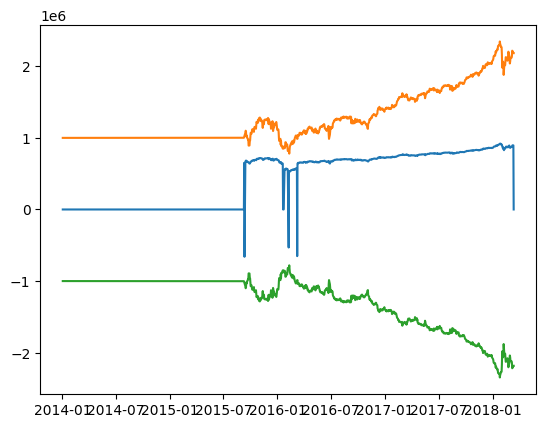

In [1323]:
plt.plot(data2_train['Theta'])
plt.plot(data2_train['V']*L)
plt.plot(-data2_train['V']*L)

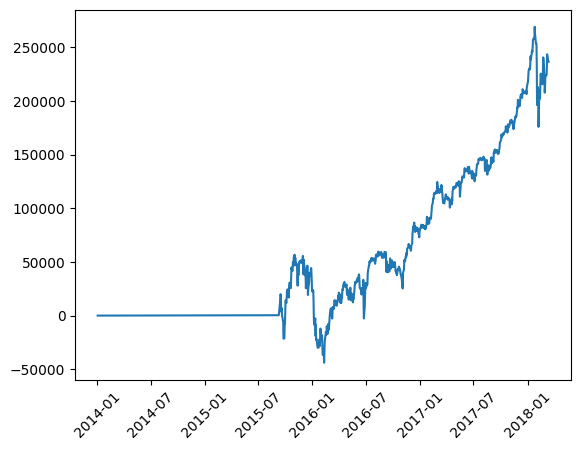

In [1324]:
plt.plot(data2_train['PnL'].cumsum())
plt.xticks(rotation=45)
plt.show()

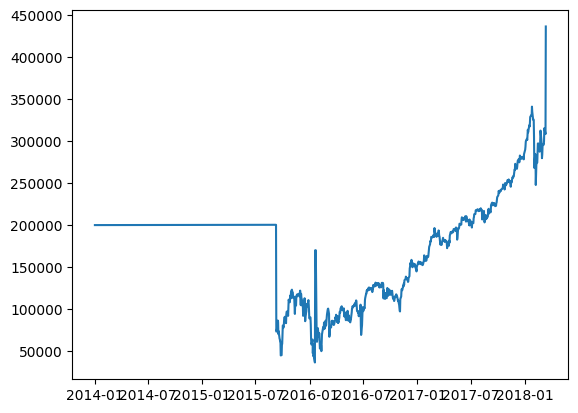

In [1325]:
plt.plot(data2_train['cash'])

### Test set peroformance

In [1566]:
V0 = 200000
L = 5
#innitialize the dataframe
data2_test['capital profit'] = np.zeros(len(data2_test))
data2_test['PnL'] = np.zeros(len(data2_test))
data2_test['capital profit'][0] = data2_test['Rate (%)'][0] * 0.01 * V0
data2_test['PnL'][0] = data2_test['capital profit'][0]
data2_test['position'] = np.zeros(len(data2_test))
data2_test['cash'] = np.zeros(len(data2_test))
data2_test['cash'][0] = V0
data2_test['Theta'] = np.zeros(len(data2_test))
data2_test['V'] = np.zeros(len(data2_test))
data2_test['cash'][0] = data2_test['cash'][0] + data2_test['PnL'][0]
data2_test['Theta'][0] = data2_test['position'][0]* data2_test['Close'][0]
data2_test['V'][0] = V0 + data2_test['PnL'][0]
buy_entry = 0
sell_entry = 0
"""
for i in range(1,rolling_window-1):
    data2_train['position'][i] = 0
    data2_train['cash'][i] = data2_train['cash'][i-1]
    data2_train['capital profit'][i] = data2_train['Rate (%)'][i] * 0.01 * data2_train['cash'][i]
    data2_train['PnL'][i] = data2_train['capital profit'][i]
    data2_train['cash'][i] = data2_train['cash'][i] + data2_train['PnL'][i]
    data2_train['Theta'][i] = data2_train['position'][i]* data2_train['Close'][i]
    data2_train['V'][i] = data2_train['V'][i-1] + data2_train['PnL'][i]
"""
for i in range(1, len(data2_test)):
    if i == len(data2_test)-1:
        data2_test['position'][i] = 0
        data2_test['cash'][i] = data2_test['cash'][i-1] + abs(data2_test['position'][i-1]) * sell_entry/L if sell_entry != 0 else data2_test['cash'][i-1] + abs(data2_test['position'][i-1]) * buy_entry/L
        data2_test['capital profit'][i] = data2_test['Rate (%)'][i] * 0.01 * data2_test['cash'][i]
        data2_test['PnL'][i] = data2_test['capital profit'][i]
        data2_test['cash'][i] = data2_test['cash'][i] + data2_test['PnL'][i]
        data2_test['Theta'][i] = data2_test['position'][i]* data2_test['Close'][i]
        data2_test['V'][i] = data2_test['V'][i-1] + data2_test['PnL'][i]
        break
    
    if data2_test['signal'][i] == 1 and buy_entry == 0:
        data2_test['position'][i] = 0
        data2_test['cash'][i] = data2_test['cash'][i-1] + abs(data2_test['position'][i-1]) * sell_entry/L
        sell_entry = 0
        sell_date = -1
        buy_entry = data2_test['Close'][i]
        buy_date = i
        data2_test['position'][i] = math.floor((L * data2_test['cash'][i] * 0.65) / data2_test['Close'][i])
        data2_test['cash'][i] = data2_test['cash'][i] - data2_test['position'][i] * data2_test['Close'][i]/L
        data2_test['capital profit'][i] = data2_test['Rate (%)'][i] * 0.01 * data2_test['cash'][i]
        data2_test['PnL'][i] = data2_test['position'][i] *data2_test['Close'][i] * data2_test['Excess return'][i] + data2_test['capital profit'][i]
        data2_test['cash'][i] = data2_test['cash'][i] + data2_test['PnL'][i]
    
    elif data2_test['signal'][i] == -1 and sell_entry == 0:
        data2_test['position'][i] = 0
        data2_test['cash'][i] = data2_test['cash'][i-1] + abs(data2_test['position'][i-1]) * buy_entry/L
        buy_entry = 0
        buy_date = -1
        sell_entry = data2_test['Close'][i]
        sell_date = i
        data2_test['position'][i] = -math.floor((L * data2_test['cash'][i] * 0.65) / data2_test['Close'][i])
        data2_test['cash'][i] = data2_test['cash'][i] - abs(data2_test['position'][i]) * data2_test['Close'][i]/L
        data2_test['capital profit'][i] = data2_test['Rate (%)'][i] * 0.01 * data2_test['cash'][i]
        data2_test['PnL'][i] = data2_test['position'][i] *data2_test['Close'][i] * data2_test['Excess return'][i] + data2_test['capital profit'][i]
        data2_test['cash'][i] = data2_test['cash'][i] + data2_test['PnL'][i]

    elif buy_entry!= 0 and data2_test['PnL'][buy_date:i].sum() < data2_test['Theta'][buy_date] * -0.05:
        data2_test['position'][i] = 0
        data2_test['cash'][i] = data2_test['cash'][i-1] + abs(data2_test['position'][i-1]) * buy_entry/L
        buy_entry = 0
        buy_date = 0
        data2_test['capital profit'][i] = data2_test['Rate (%)'][i] * 0.01 * data2_test['cash'][i]
        data2_test['PnL'][i] =  data2_test['capital profit'][i]
        data2_test['cash'][i] = data2_test['cash'][i] + data2_test['PnL'][i]
    elif sell_entry!= 0 and data2_test['PnL'][sell_date:i].sum() < data2_test['Theta'][sell_date] * -0.05:
        data2_test['position'][i] = 0
        data2_test['cash'][i] = data2_test['cash'][i-1] + abs(data2_test['position'][i-1]) * sell_entry/L
        sell_entry = 0
        sell_date = 0
        data2_test['capital profit'][i] = data2_test['Rate (%)'][i] * 0.01 * data2_test['cash'][i]
        data2_test['PnL'][i] = data2_test['capital profit'][i]
        data2_test['cash'][i] = data2_test['cash'][i] + data2_test['PnL'][i]
    #if the signal is the same as the previous day, then the position and cash remain the same
    else:
        data2_test['position'][i] = data2_test['position'][i-1]
        data2_test['cash'][i] = data2_test['cash'][i-1]
        data2_test['capital profit'][i] = data2_test['Rate (%)'][i] * 0.01 * data2_test['cash'][i]
        data2_test['PnL'][i] = data2_test['position'][i] *data2_test['Close'][i] * data2_test['Excess return'][i] + data2_test['capital profit'][i]
        data2_test['cash'][i] = data2_test['cash'][i] + data2_test['PnL'][i]
    #if the signal is the same as the previous day, then the position and cash remain the same
    """
    elif data2_test['signal'][i] == data2_test['signal'][i-1] == -1:
        data2_test['position'][i] = data2_test['position'][i-1]
        data2_test['cash'][i] = data2_test['cash'][i-1]
        data2_test['capital profit'][i] = data2_test['Rate (%)'][i] * 0.01 * data2_test['cash'][i]
        data2_test['PnL'][i] = data2_test['position'][i] *data2_test['Close'][i] * data2_test['Excess return'][i] + data2_test['capital profit'][i]
        data2_test['cash'][i] = data2_test['cash'][i] + data2_test['PnL'][i]
    """
    
    data2_test['Theta'][i] = data2_test['position'][i]* data2_test['Close'][i]
    data2_test['V'][i] = data2_test['V'][i-1] + data2_test['PnL'][i]

C:\Users\47965\AppData\Local\Temp\ipykernel_24796\1398058357.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2_test['capital profit'][0] = data2_test['Rate (%)'][0] * 0.01 * V0
C:\Users\47965\AppData\Local\Temp\ipykernel_24796\1398058357.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2_test['PnL'][0] = data2_test['capital profit'][0]
C:\Users\47965\AppData\Local\Temp\ipykernel_24796\1398058357.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

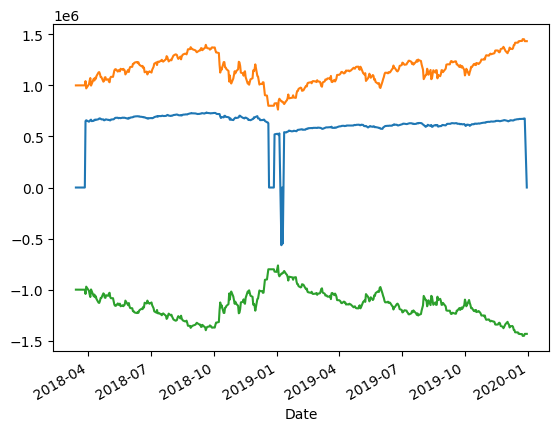

In [1567]:
data2_test['Theta'].plot()
plt.plot(abs(data2_test['V'])*L)
plt.plot(-abs(data2_test['V'])*L)

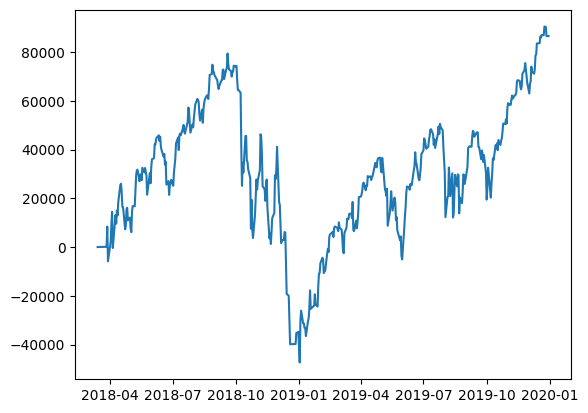

In [1568]:
plt.plot(data2_test['PnL'].cumsum())

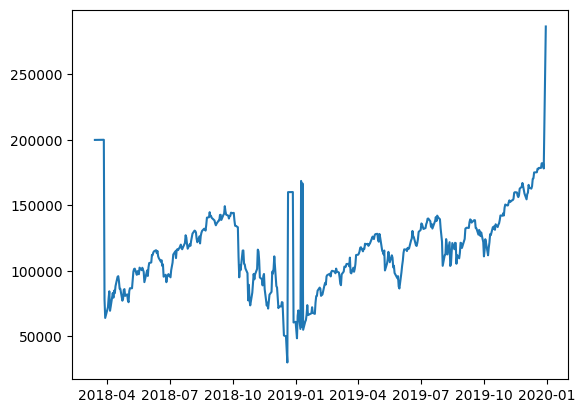

In [1569]:
plt.plot(data2_test['cash'])

### ARIMA-GARCH model

In [1056]:
from arch import arch_model
from scipy.stats import shapiro

In [498]:
data3 = assets.copy()
data3_train = training_set.copy()
data3_test = test_set.copy()

find optimal parameters for ARIMA-GARCH model

In [1229]:
data3_train['predict_close'] = np.zeros(len(data3_train))
window = 300
sqare_error = []
for i in range(window,len(data3_train)-1):
    model = ARIMA(data3['Close'][:i+1], order=(3,2,3)).fit()
    arima_pred = model.forecast(1).iloc[0]
    temp = (data2_train['predict_close'][i] - data2['Close'][i+1])**2
    sqare_error.append(temp)
    residuals = pd.DataFrame(model.resid[1:])
    shapiro_test = shapiro(residuals)
    if shapiro_test.pvalue < 0.05:
        model_garch = arch_model(residuals,vol='Garch', p=1, q=1,dist='Normal').fit(disp='off')
        garch_pred = model_garch.forecast(horizon=1)
        data3_train['predict_close'][i] = arima_pred + garch_pred.mean["h.1"].iloc[-1]
    else:
        data3_train['predict_close'][i] = arima_pred

mse = np.array(sqare_error).mean()
print(mse)

c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index b

In [967]:
data3_test['predict_close'] = np.zeros(len(data3_test))
for i in range(len(data3_train),len(data3)-1):
    model = ARIMA(data3['Close'][:i+1], order=(5,1,3)).fit()
    arima_pred = model.forecast(1).iloc[0]
    
    residuals = pd.DataFrame(model.resid[1:])
    shapiro_test = shapiro(residuals)
    if shapiro_test.pvalue < 0.05:
        model_garch = arch_model(residuals,vol='Garch', p=1, q=1,dist='Normal').fit(disp='off')
        garch_pred = model_garch.forecast(horizon=1)
        data3_test['predict_close'][i-len(data3_train)] = arima_pred + garch_pred.mean["h.1"].iloc[-1]
    else:
        data3_test['predict_close'][i-len(data3_train)] = arima_pred

c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting param

In [1553]:
window =300
data3_train['signal'] = np.where((data3_train['predict_close']-data3_train['Close'])/data3_train['Close'] > 0.003 , 1, 0)
data3_train['signal'] = np.where((data3_train['predict_close']-data3_train['Close'])/data3_train['Close'] < -0.004, -1, data3_train['signal'])
for i in range(window):
    data3_train['signal'][i] = 0

C:\Users\47965\AppData\Local\Temp\ipykernel_24796\3279021290.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3_train['signal'][i] = 0


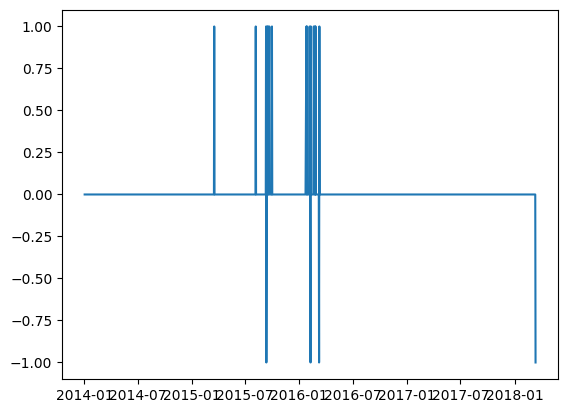

In [1554]:
plt.plot(data3_train['signal'])

In [1555]:
data3_test['signal'] = np.where((data3_test['predict_close']-data3_test['Close'])/data3_test['Close'] > 0.003 , 1, 0)
data3_test['signal'] = np.where((data3_test['predict_close']-data3_test['Close'])/data3_test['Close'] < -0.004, -1, data3_test['signal'])

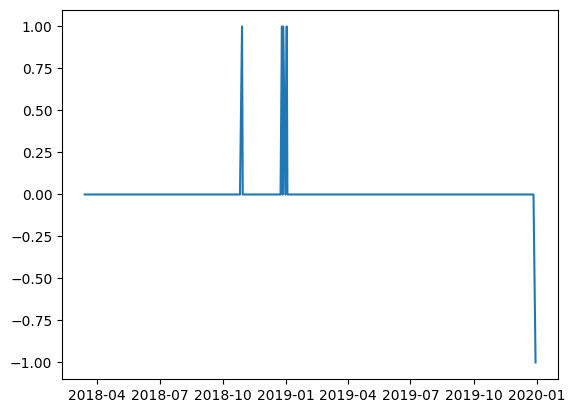

In [1556]:
plt.plot(data3_test['signal'])

In [1659]:
V0 = 200000
L = 5
#innitialize the dataframe
data3_train['capital profit'] = np.zeros(len(data3_train))
data3_train['PnL'] = np.zeros(len(data3_train))
data3_train['capital profit'][0] = data3_train['Rate (%)'][0] * 0.01 * V0
data3_train['PnL'][0] = data3_train['capital profit'][0]
data3_train['position'] = np.zeros(len(data3_train))
data3_train['cash'] = np.zeros(len(data3_train))
data3_train['cash'][0] = V0
data3_train['Theta'] = np.zeros(len(data3_train))
data3_train['V'] = np.zeros(len(data3_train))
data3_train['cash'][0] = data3_train['cash'][0] + data3_train['PnL'][0]
data3_train['Theta'][0] = data3_train['position'][0]* data3_train['Close'][0]
data3_train['V'][0] = V0 + data3_train['PnL'][0]
buy_entry = 0
sell_entry = 0
"""
for i in range(1,rolling_window-1):
    data2_train['position'][i] = 0
    data2_train['cash'][i] = data2_train['cash'][i-1]
    data2_train['capital profit'][i] = data2_train['Rate (%)'][i] * 0.01 * data2_train['cash'][i]
    data2_train['PnL'][i] = data2_train['capital profit'][i]
    data2_train['cash'][i] = data2_train['cash'][i] + data2_train['PnL'][i]
    data2_train['Theta'][i] = data2_train['position'][i]* data2_train['Close'][i]
    data2_train['V'][i] = data2_train['V'][i-1] + data2_train['PnL'][i]
"""
for i in range(1, len(data3_train)):
    if i == len(data3_train)-1:
        data3_train['position'][i] = 0
        data3_train['cash'][i] = data3_train['cash'][i-1] + abs(data3_train['position'][i-1]) * sell_entry/L if sell_entry != 0 else data3_train['cash'][i-1] + abs(data3_train['position'][i-1]) * buy_entry/L
        data3_train['capital profit'][i] = data3_train['Rate (%)'][i] * 0.01 * data3_train['cash'][i]
        data3_train['PnL'][i] = data3_train['capital profit'][i]
        data3_train['cash'][i] = data3_train['cash'][i] + data3_train['PnL'][i]
        data3_train['Theta'][i] = data3_train['position'][i]* data3_train['Close'][i]
        data3_train['V'][i] = data3_train['V'][i-1] + data3_train['PnL'][i]
        break
    
    if data3_train['signal'][i] == 1 and buy_entry == 0:
        data3_train['position'][i] = 0
        data3_train['cash'][i] = data3_train['cash'][i-1] + abs(data3_train['position'][i-1]) * sell_entry/L
        sell_entry = 0
        sell_date = -1
        buy_entry = data3_train['Close'][i]
        buy_date = i
        data3_train['position'][i] = math.floor((L * data3_train['cash'][i] * 0.65) / data3_train['Close'][i])
        data3_train['cash'][i] = data3_train['cash'][i] - data3_train['position'][i] * data3_train['Close'][i]/L
        data3_train['capital profit'][i] = data3_train['Rate (%)'][i] * 0.01 * data3_train['cash'][i]
        data3_train['PnL'][i] = data3_train['position'][i] *data3_train['Close'][i] * data3_train['Excess return'][i] + data3_train['capital profit'][i]
        data3_train['cash'][i] = data3_train['cash'][i] + data3_train['PnL'][i]
    
    elif data3_train['signal'][i] == -1 and sell_entry == 0:
        data3_train['position'][i] = 0
        data3_train['cash'][i] = data3_train['cash'][i-1] + abs(data3_train['position'][i-1]) * buy_entry/L
        buy_entry = 0
        buy_date = -1
        sell_entry = data3_train['Close'][i]
        sell_date = i
        data3_train['position'][i] = -math.floor((L * data3_train['cash'][i] * 0.65) / data3_train['Close'][i])
        data3_train['cash'][i] = data3_train['cash'][i] - abs(data3_train['position'][i]) * data3_train['Close'][i]/L
        data3_train['capital profit'][i] = data3_train['Rate (%)'][i] * 0.01 * data3_train['cash'][i]
        data3_train['PnL'][i] = data3_train['position'][i] *data3_train['Close'][i] * data3_train['Excess return'][i] + data3_train['capital profit'][i]
        data3_train['cash'][i] = data3_train['cash'][i] + data3_train['PnL'][i]

    elif buy_entry!= 0 and data3_train['PnL'][buy_date:i].sum() < data3_train['Theta'][buy_date] * -0.05:
        data3_train['position'][i] = 0
        data3_train['cash'][i] = data3_train['cash'][i-1] + abs(data3_train['position'][i-1]) * buy_entry/L
        buy_entry = 0
        buy_date = 0
        data3_train['capital profit'][i] = data3_train['Rate (%)'][i] * 0.01 * data3_train['cash'][i]
        data3_train['PnL'][i] =  data3_train['capital profit'][i]
        data3_train['cash'][i] = data3_train['cash'][i] + data3_train['PnL'][i]
    elif sell_entry!= 0 and data3_train['PnL'][sell_date:i].sum() < data3_train['Theta'][sell_date] * -0.05:
        data3_train['position'][i] = 0
        data3_train['cash'][i] = data3_train['cash'][i-1] + abs(data3_train['position'][i-1]) * sell_entry/L
        sell_entry = 0
        sell_date = 0
        data3_train['capital profit'][i] = data3_train['Rate (%)'][i] * 0.01 * data3_train['cash'][i]
        data3_train['PnL'][i] = data3_train['capital profit'][i]
        data3_train['cash'][i] = data3_train['cash'][i] + data3_train['PnL'][i]
    #if the signal is the same as the previous day, then the position and cash remain the same
    else:
        data3_train['position'][i] = data3_train['position'][i-1]
        data3_train['cash'][i] = data3_train['cash'][i-1]
        data3_train['capital profit'][i] = data3_train['Rate (%)'][i] * 0.01 * data3_train['cash'][i]
        data3_train['PnL'][i] = data3_train['position'][i] *data3_train['Close'][i] * data3_train['Excess return'][i] + data3_train['capital profit'][i]
        data3_train['cash'][i] = data3_train['cash'][i] + data3_train['PnL'][i]
    #if the signal is the same as the previous day, then the position and cash remain the same
    """
    elif data2_test['signal'][i] == data2_test['signal'][i-1] == -1:
        data2_test['position'][i] = data2_test['position'][i-1]
        data2_test['cash'][i] = data2_test['cash'][i-1]
        data2_test['capital profit'][i] = data2_test['Rate (%)'][i] * 0.01 * data2_test['cash'][i]
        data2_test['PnL'][i] = data2_test['position'][i] *data2_test['Close'][i] * data2_test['Excess return'][i] + data2_test['capital profit'][i]
        data2_test['cash'][i] = data2_test['cash'][i] + data2_test['PnL'][i]
    """
    
    data3_train['Theta'][i] = data3_train['position'][i]* data3_train['Close'][i]
    data3_train['V'][i] = data3_train['V'][i-1] + data3_train['PnL'][i]

C:\Users\47965\AppData\Local\Temp\ipykernel_24796\1790096852.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3_train['capital profit'][0] = data3_train['Rate (%)'][0] * 0.01 * V0
C:\Users\47965\AppData\Local\Temp\ipykernel_24796\1790096852.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3_train['PnL'][0] = data3_train['capital profit'][0]
C:\Users\47965\AppData\Local\Temp\ipykernel_24796\1790096852.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

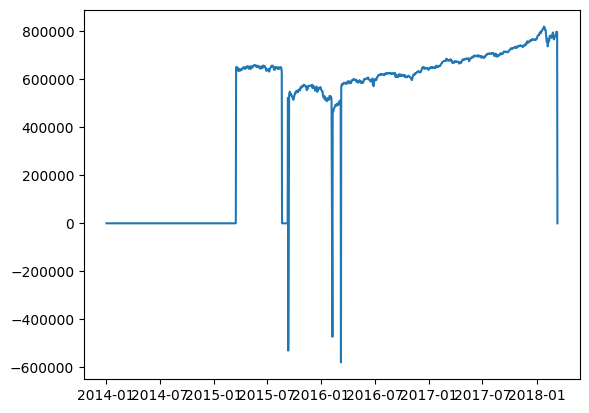

In [1660]:
plt.plot(data3_train['Theta'])

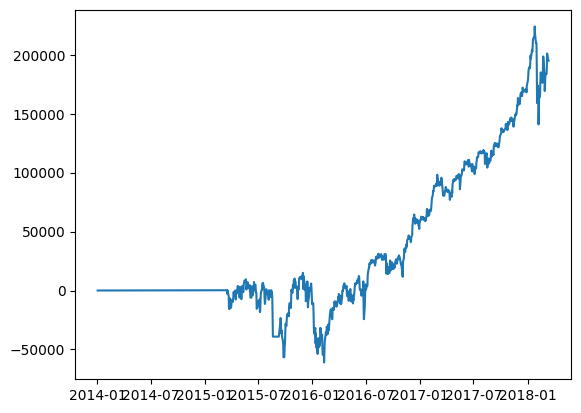

In [1661]:
plt.plot(data3_train['PnL'].cumsum())

In [1560]:
V0 = 200000
L = 5
#innitialize the dataframe
data3_test['capital profit'] = np.zeros(len(data3_test))
data3_test['PnL'] = np.zeros(len(data3_test))
data3_test['capital profit'][0] = data3_test['Rate (%)'][0] * 0.01 * V0
data3_test['PnL'][0] = data3_test['capital profit'][0]
data3_test['position'] = np.zeros(len(data3_test))
data3_test['cash'] = np.zeros(len(data3_test))
data3_test['cash'][0] = V0
data3_test['Theta'] = np.zeros(len(data3_test))
data3_test['V'] = np.zeros(len(data3_test))
data3_test['cash'][0] = data3_test['cash'][0] + data3_test['PnL'][0]
data3_test['Theta'][0] = data3_test['position'][0]* data3_test['Close'][0]
data3_test['V'][0] = V0 + data3_test['PnL'][0]
buy_entry = 0
sell_entry = 0
"""
for i in range(1,rolling_window-1):
    data2_train['position'][i] = 0
    data2_train['cash'][i] = data2_train['cash'][i-1]
    data2_train['capital profit'][i] = data2_train['Rate (%)'][i] * 0.01 * data2_train['cash'][i]
    data2_train['PnL'][i] = data2_train['capital profit'][i]
    data2_train['cash'][i] = data2_train['cash'][i] + data2_train['PnL'][i]
    data2_train['Theta'][i] = data2_train['position'][i]* data2_train['Close'][i]
    data2_train['V'][i] = data2_train['V'][i-1] + data2_train['PnL'][i]
"""
for i in range(1, len(data3_test)):
    if i == len(data3_test)-1:
        data3_test['position'][i] = 0
        data3_test['cash'][i] = data3_test['cash'][i-1] + abs(data3_test['position'][i-1]) * sell_entry/L if sell_entry != 0 else data3_test['cash'][i-1] + abs(data3_test['position'][i-1]) * buy_entry/L
        data3_test['capital profit'][i] = data3_test['Rate (%)'][i] * 0.01 * data3_test['cash'][i]
        data3_test['PnL'][i] = data3_test['capital profit'][i]
        data3_test['cash'][i] = data3_test['cash'][i] + data3_test['PnL'][i]
        data3_test['Theta'][i] = data3_test['position'][i]* data3_test['Close'][i]
        data3_test['V'][i] = data3_test['V'][i-1] + data3_test['PnL'][i]
        break
    
    if data3_test['signal'][i] == 1 and buy_entry == 0:
        data3_test['position'][i] = 0
        data3_test['cash'][i] = data3_test['cash'][i-1] + abs(data3_test['position'][i-1]) * sell_entry/L
        sell_entry = 0
        sell_date = -1
        buy_entry = data3_test['Close'][i]
        buy_date = i
        data3_test['position'][i] = math.floor((L * data3_test['cash'][i] * 0.65) / data3_test['Close'][i])
        data3_test['cash'][i] = data3_test['cash'][i] - data3_test['position'][i] * data3_test['Close'][i]/L
        data3_test['capital profit'][i] = data3_test['Rate (%)'][i] * 0.01 * data3_test['cash'][i]
        data3_test['PnL'][i] = data3_test['position'][i] *data3_test['Close'][i] * data3_test['Excess return'][i] + data3_test['capital profit'][i]
        data3_test['cash'][i] = data3_test['cash'][i] + data3_test['PnL'][i]
    
    elif data3_test['signal'][i] == -1 and sell_entry == 0:
        data3_test['position'][i] = 0
        data3_test['cash'][i] = data3_test['cash'][i-1] + abs(data3_test['position'][i-1]) * buy_entry/L
        buy_entry = 0
        buy_date = -1
        sell_entry = data3_test['Close'][i]
        sell_date = i
        data3_test['position'][i] = -math.floor((L * data3_test['cash'][i] * 0.65) / data3_test['Close'][i])
        data3_test['cash'][i] = data3_test['cash'][i] - abs(data3_test['position'][i]) * data3_test['Close'][i]/L
        data3_test['capital profit'][i] = data3_test['Rate (%)'][i] * 0.01 * data3_test['cash'][i]
        data3_test['PnL'][i] = data3_test['position'][i] *data3_test['Close'][i] * data3_test['Excess return'][i] + data3_test['capital profit'][i]
        data3_test['cash'][i] = data3_test['cash'][i] + data3_test['PnL'][i]

    elif buy_entry!= 0 and data3_test['PnL'][buy_date:i].sum() < data3_test['Theta'][buy_date] * -0.01:
        data3_test['position'][i] = 0
        data3_test['cash'][i] = data3_test['cash'][i-1] + abs(data3_test['position'][i-1]) * buy_entry/L
        buy_entry = 0
        buy_date = 0
        data3_test['capital profit'][i] = data3_test['Rate (%)'][i] * 0.01 * data3_test['cash'][i]
        data3_test['PnL'][i] =  data3_test['capital profit'][i]
        data3_test['cash'][i] = data3_test['cash'][i] + data3_test['PnL'][i]
    elif sell_entry!= 0 and data3_test['PnL'][sell_date:i].sum() < data3_test['Theta'][sell_date] * -0.01:
        data3_test['position'][i] = 0
        data3_test['cash'][i] = data3_test['cash'][i-1] + abs(data3_test['position'][i-1]) * sell_entry/L
        sell_entry = 0
        sell_date = 0
        data3_test['capital profit'][i] = data3_test['Rate (%)'][i] * 0.01 * data3_test['cash'][i]
        data3_test['PnL'][i] = data3_test['capital profit'][i]
        data3_test['cash'][i] = data3_test['cash'][i] + data3_test['PnL'][i]
    #if the signal is the same as the previous day, then the position and cash remain the same
    else:
        data3_test['position'][i] = data3_test['position'][i-1]
        data3_test['cash'][i] = data3_test['cash'][i-1]
        data3_test['capital profit'][i] = data3_test['Rate (%)'][i] * 0.01 * data3_test['cash'][i]
        data3_test['PnL'][i] = data3_test['position'][i] *data3_test['Close'][i] * data3_test['Excess return'][i] + data3_test['capital profit'][i]
        data3_test['cash'][i] = data3_test['cash'][i] + data3_test['PnL'][i]
    #if the signal is the same as the previous day, then the position and cash remain the same
    """
    elif data2_test['signal'][i] == data2_test['signal'][i-1] == -1:
        data2_test['position'][i] = data2_test['position'][i-1]
        data2_test['cash'][i] = data2_test['cash'][i-1]
        data2_test['capital profit'][i] = data2_test['Rate (%)'][i] * 0.01 * data2_test['cash'][i]
        data2_test['PnL'][i] = data2_test['position'][i] *data2_test['Close'][i] * data2_test['Excess return'][i] + data2_test['capital profit'][i]
        data2_test['cash'][i] = data2_test['cash'][i] + data2_test['PnL'][i]
    """
    
    data3_test['Theta'][i] = data3_test['position'][i]* data3_test['Close'][i]
    data3_test['V'][i] = data3_test['V'][i-1] + data3_test['PnL'][i]

C:\Users\47965\AppData\Local\Temp\ipykernel_24796\1060331211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3_test['capital profit'][0] = data3_test['Rate (%)'][0] * 0.01 * V0
C:\Users\47965\AppData\Local\Temp\ipykernel_24796\1060331211.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data3_test['PnL'][0] = data3_test['capital profit'][0]
C:\Users\47965\AppData\Local\Temp\ipykernel_24796\1060331211.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [1561]:
data3_test[data3_test['signal']==1]

Close  Rate (%)    Return  Excess return  predict_close  \
Date                                                                       
2018-10-29  263.859985  0.008730  0.014818       0.014731     264.994522   
2018-12-26  246.179993  0.009524  0.007677       0.007582     247.003521   
2018-12-28  247.750000  0.009524  0.008759       0.008664     248.773753   
2019-01-02  250.179993  0.009524 -0.023863      -0.023958     250.962231   

            signal  capital profit           PnL  position          cash  \
Date                                                                       
2018-10-29       1        6.184891   9692.509811    2492.0  80537.625083   
2018-12-26       1        6.373403   4715.726826    2523.0  71636.458078   
2018-12-28       1        6.740599   5422.115194    2523.0  76198.409634   
2019-01-02       1        7.314436 -15115.074824    2523.0  61686.505737   

                    Theta              V  
Date                                      
2018-10-29  657539.083496  212045.441782  
2018-12-26  621112.121521  195858.882383  
2018-12-28  625073.250000  200420.833938  
2019-01-02  631204.121521  185908.930041

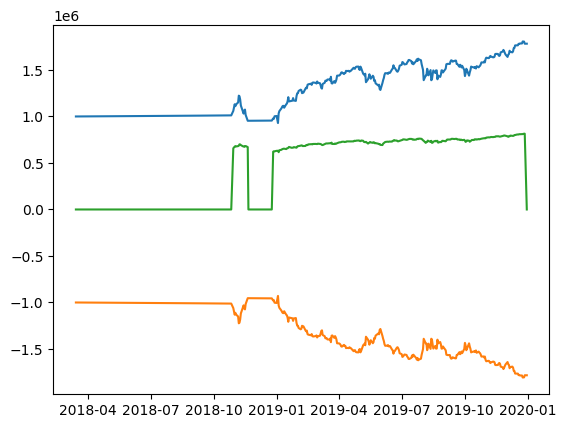

In [1562]:
plt.plot(data3_test['V']*L)
plt.plot(-data3_test['V']*L)
plt.plot(data3_test['Theta'])

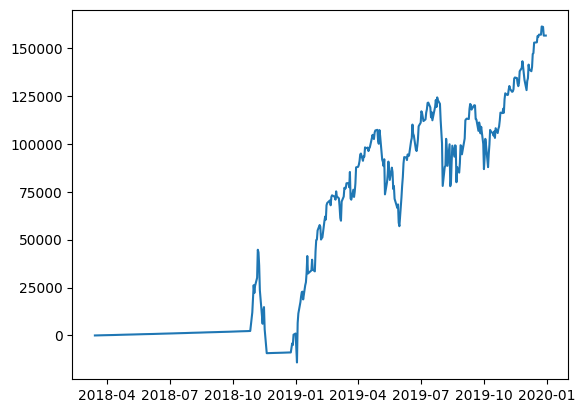

In [1563]:
plt.plot(data3_test['PnL'].cumsum())

## 2.(b) Position & Turnover dollar

Theta 

C:\Users\47965\AppData\Local\Temp\ipykernel_24796\1749193430.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(ax0.get_xticklabels())
C:\Users\47965\AppData\Local\Temp\ipykernel_24796\1749193430.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels())
C:\Users\47965\AppData\Local\Temp\ipykernel_24796\1749193430.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels())
C:\Users\47965\AppData\Local\Temp\ipykernel_24796\1749193430.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.set_xticklabels(ax5.get_xticklabels())
C:\Users\47965\AppData\Local\Temp\ipykernel_24796\1749193430.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(ax3.get_xticklabels())
C:\Users\47965\AppData\Local\Temp\ipykernel_24796\1749193430

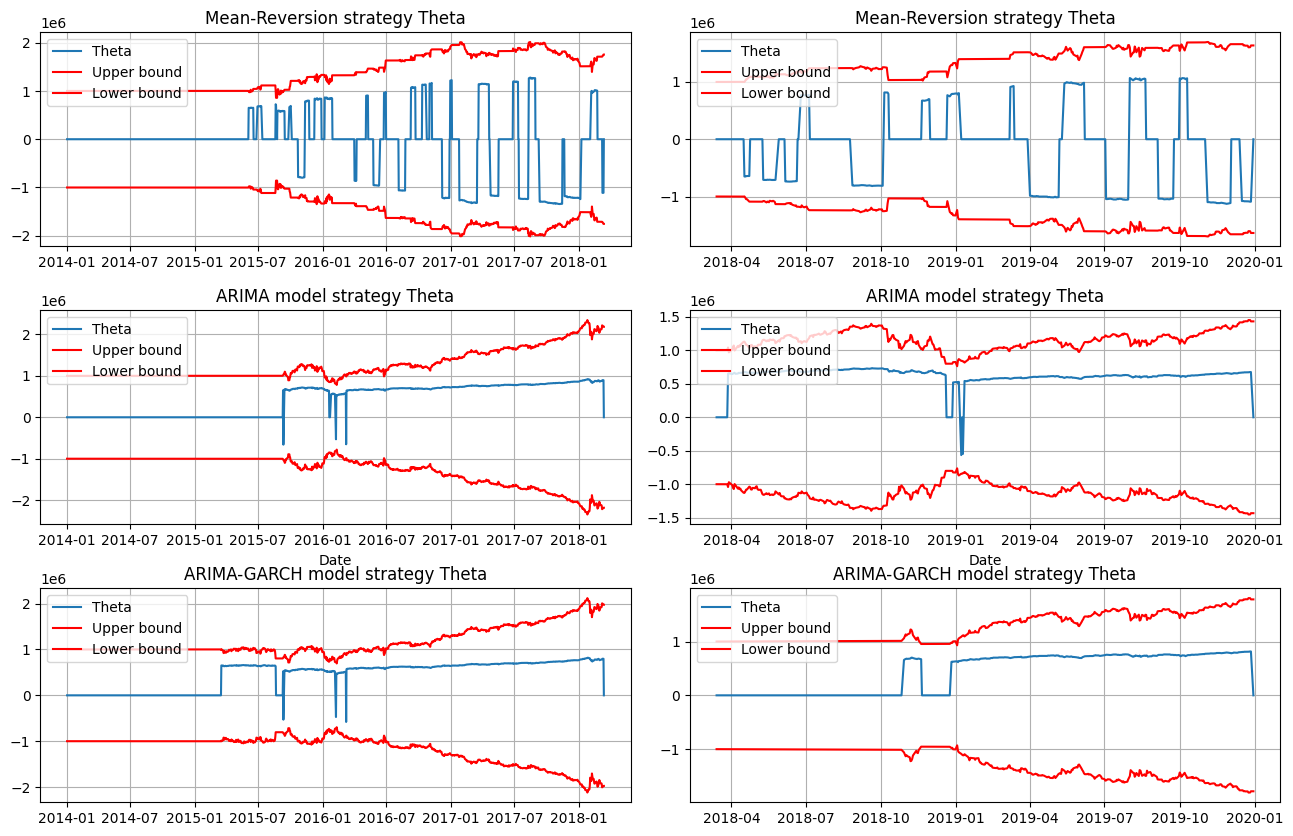

In [1588]:
fig, ((ax1,ax3),(ax2,ax4),(ax0,ax5)) = plt.subplots(3, 2, sharex=False, figsize=(16, 10))

#ax0 = plt.subplot(3,0,0)
ax0.plot(data3_train['Theta'],label='Theta')
ax0.plot(data3_train['V']*L,'r-',label='Upper bound')
ax0.plot(-data3_train['V']*L,'r-',label='Lower bound')
ax0.legend(loc='upper left')
ax0.grid(True)
ax0.set_title('ARIMA-GARCH model strategy Theta')
ax0.set_xticklabels(ax0.get_xticklabels())
#ax1 = plt.subplot(3,1,0)
ax1.plot(data_train['Theta'],label='Theta')
ax1.plot(data_train['V']*L,'r-',label='Upper bound')
ax1.plot(-data_train['V']*L,'r-',label='Lower bound')
ax1.legend(loc='upper left')
ax1.grid(True)
ax1.set_title('Mean-Reversion strategy Theta')
ax1.set_xticklabels(ax1.get_xticklabels())
#ax2 = plt.subplot(3,2,0)
ax2.plot(data2_train['Theta'],label='Theta')
ax2.plot(data2_train['V']*L,'r-',label='Upper bound')
ax2.plot(-data2_train['V']*L,'r-',label='Lower bound')
ax2.legend(loc='upper left')
ax2.grid(True)
ax2.set_xlabel('Date')
ax2.set_title('ARIMA model strategy Theta')
ax2.set_xticklabels(ax2.get_xticklabels())

#ax0 = plt.subplot(3,0,0)
ax5.plot(data3_test['Theta'],label='Theta')
ax5.plot(data3_test['V']*L,'r-',label='Upper bound')
ax5.plot(-data3_test['V']*L,'r-',label='Lower bound')
ax5.legend(loc='upper left')
ax5.grid(True)
ax5.set_title('ARIMA-GARCH model strategy Theta')
ax5.set_xticklabels(ax5.get_xticklabels())
#ax1 = plt.subplot(3,1,0)
ax3.plot(data_test['Theta'],label='Theta')
ax3.plot(data_test['V']*L,'r-',label='Upper bound')
ax3.plot(-data_test['V']*L,'r-',label='Lower bound')
ax3.legend(loc='upper left')
ax3.grid(True)
ax3.set_title('Mean-Reversion strategy Theta')
ax3.set_xticklabels(ax3.get_xticklabels())
#ax2 = plt.subplot(3,2,0)
ax4.plot(data2_test['Theta'],label='Theta')
ax4.plot(data2_test['V']*L,'r-',label='Upper bound')
ax4.plot(-data2_test['V']*L,'r-',label='Lower bound')
ax4.legend(loc='upper left')
ax4.grid(True)
ax4.set_xlabel('Date')
ax4.set_title('ARIMA model strategy Theta')
ax4.set_xticklabels(ax4.get_xticklabels())



plt.subplots_adjust(wspace=0.1, hspace=0.3)
#savefig
plt.savefig('Theta_train.pdf',dpi=800)
plt.show()

In [1589]:
# turnover dollars for mean-reversion strategy train
turn_over_dollar1 = data_train['Theta'].diff().abs().sum()
print('turnover dollars for mean reversion is $%d' % turn_over_dollar1)
turn_over_units1 = (data_train['Theta']/data_train['Close']).diff().abs().sum()
print('turnover units for mean-reversion is %d' % turn_over_units1)

turnover dollars for mean reversion is $59693540
turnover units for mean-reversion is 259442


In [1573]:
# turnover dollars for ARIMA strategy train
turn_over_dollar2 = data2_train['Theta'].diff().abs().sum()
print('turnover dollars for ARIMA is $%d' % turn_over_dollar2)
turn_over_units2 = (data2_train['Theta']/data2_train['Close']).diff().abs().sum()
print('turnover units for ARIMA is %d' % turn_over_units2)

turnover dollars for ARIMA is $12324235
turnover units for ARIMA is 50526


In [1574]:
# turnover dollars for ARIMA-GARCH strategy train
turn_over_dollar3 = data3_train['Theta'].diff().abs().sum()
print('turnover dollars for ARIMA-GARCH is $%d' % turn_over_dollar3)
turn_over_units3 = (data3_train['Theta']/data3_train['Close']).diff().abs().sum()
print('turnover units for ARIMA-GARCH is %d' % turn_over_units3)

turnover dollars for ARIMA-GARCH is $11284485
turnover units for ARIMA-GARCH is 44160


In [1575]:
# turnover dollars for mean-reversion strategy test
turn_over_dollar4 = data_test['Theta'].diff().abs().sum()
print('turnover dollars for mean reversion is $%d' % turn_over_dollar4)
turn_over_units4 = (data_test['Theta']/data_test['Close']).diff().abs().sum()
print('turnover units for mean-reversion is %d' % turn_over_units4)

turnover dollars for mean reversion is $31465052
turnover units for mean-reversion is 106554


In [1576]:
# turnover dollars for ARIMA strategy test
turn_over_dollar5 = data2_test['Theta'].diff().abs().sum()
print('turnover dollars for ARIMA is $%d' % turn_over_dollar5)
turn_over_units5 = (data2_test['Theta']/data2_test['Close']).diff().abs().sum()
print('turnover units for ARIMA is %d' % turn_over_units5)

turnover dollars for ARIMA is $7441522
turnover units for ARIMA is 22084


In [1577]:
# turnover dollars for ARIMA-GARCH strategy test
turn_over_dollar6 = data3_test['Theta'].diff().abs().sum()
print('turnover dollars for ARIMA-GARCH is $%d' % turn_over_dollar6)
turn_over_units6 = (data3_test['Theta']/data3_test['Close']).diff().abs().sum()
print('turnover units for ARIMA-GARCH is %d' % turn_over_units6)

turnover dollars for ARIMA-GARCH is $3904009
turnover units for ARIMA-GARCH is 10030


C:\Users\47965\AppData\Local\Temp\ipykernel_24796\3982937509.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.set_xticklabels(ax5.get_xticklabels())


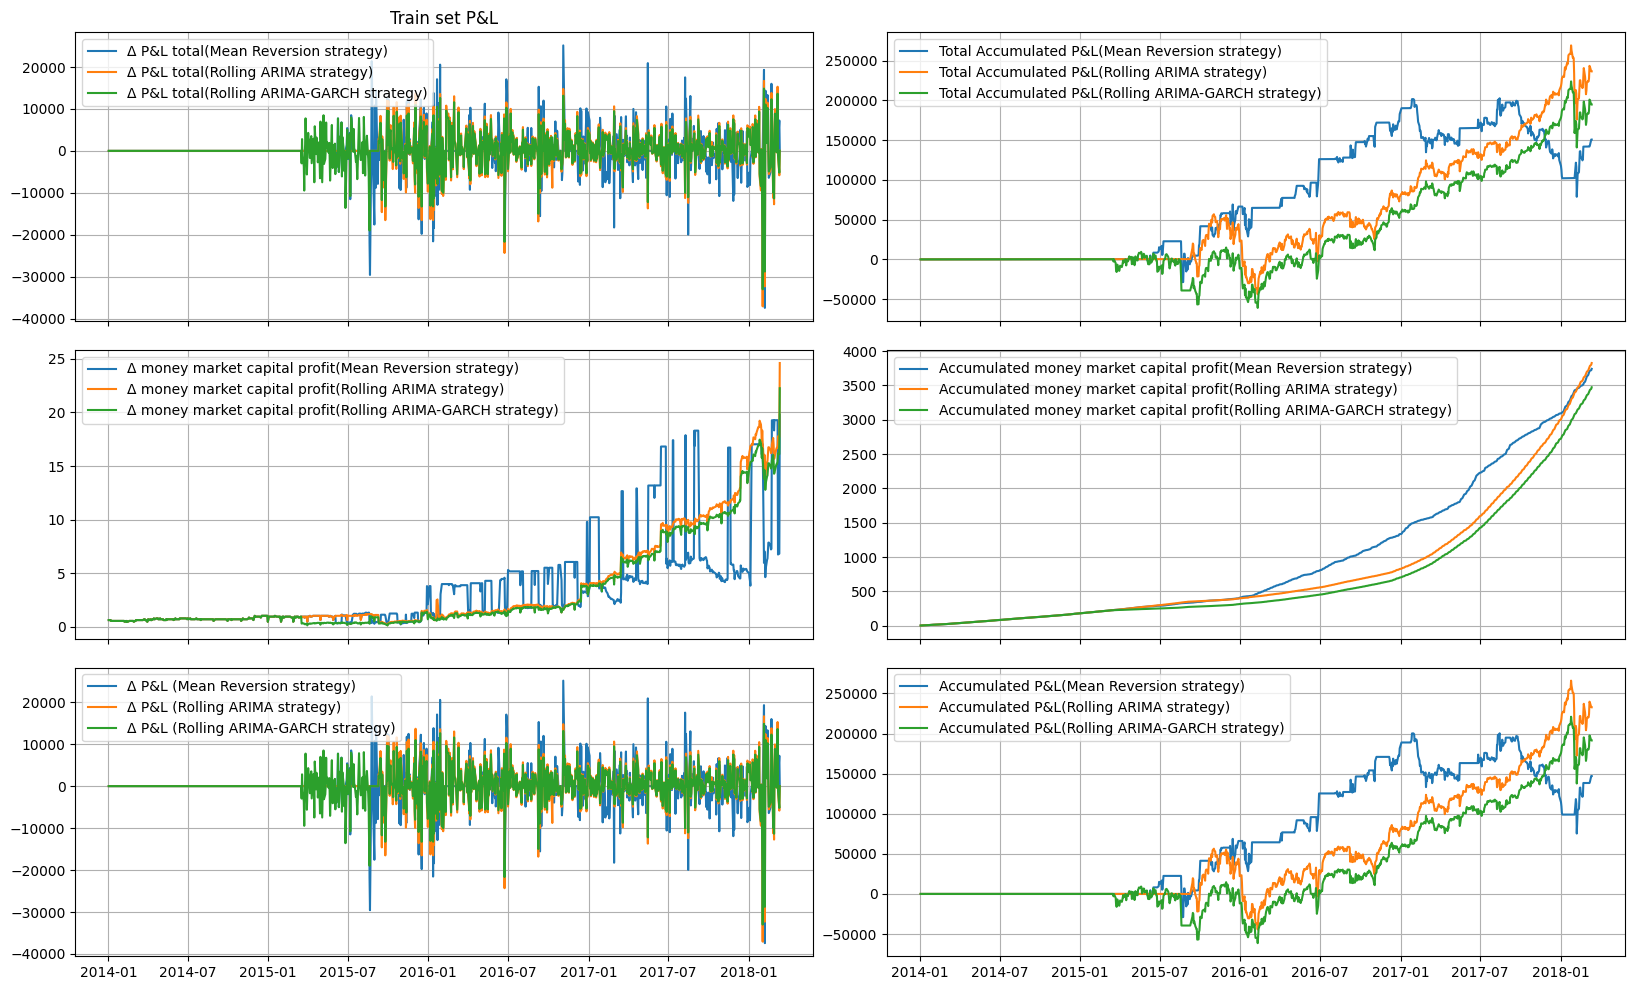

In [1590]:
fig, ((ax0,ax3),(ax1,ax4),(ax2,ax5)) = plt.subplots(3, 2, sharex=True, figsize=(20, 12))

#ax0 = plt.subplot(3,0,0)
ax0.plot(data_train['PnL'],label='\u0394 P&L total(Mean Reversion strategy)')
ax0.plot(data2_train['PnL'],label='\u0394 P&L total(Rolling ARIMA strategy)')
ax0.plot(data3_train['PnL'],label='\u0394 P&L total(Rolling ARIMA-GARCH strategy)')
ax0.legend(loc='upper left')
ax0.grid(True)
ax0.set_title('Train set P&L')

#ax1 = plt.subplot(3,1,0)
ax1.plot(data_train['capital profit'],label='\u0394 money market capital profit(Mean Reversion strategy)')
ax1.plot(data2_train['capital profit'],label='\u0394 money market capital profit(Rolling ARIMA strategy)')
ax1.plot(data3_train['capital profit'],label='\u0394 money market capital profit(Rolling ARIMA-GARCH strategy)')
ax1.legend(loc='upper left')
ax1.grid(True)

#ax2 = plt.subplot(3,2,0)
ax2.plot(data_train['PnL']-data_train['capital profit'],label='\u0394 P&L (Mean Reversion strategy)')
ax2.plot(data2_train['PnL']-data2_train['capital profit'],label='\u0394 P&L (Rolling ARIMA strategy)')
ax2.plot(data3_train['PnL']-data3_train['capital profit'],label='\u0394 P&L (Rolling ARIMA-GARCH strategy)')
ax2.legend(loc='upper left')
ax2.grid(True)

#ax3 = plt.subplot(3,0,0)
ax3.plot(data_train['PnL'].cumsum(),label='Total Accumulated P&L(Mean Reversion strategy)')
ax3.plot(data2_train['PnL'].cumsum(),label='Total Accumulated P&L(Rolling ARIMA strategy)')
ax3.plot(data3_train['PnL'].cumsum(),label='Total Accumulated P&L(Rolling ARIMA-GARCH strategy)')
ax3.legend(loc='upper left')
ax3.grid(True)

#ax4 = plt.subplot(3,1,0)
ax4.plot(data_train['capital profit'].cumsum(),label='Accumulated money market capital profit(Mean Reversion strategy)')
ax4.plot(data2_train['capital profit'].cumsum(),label='Accumulated money market capital profit(Rolling ARIMA strategy)')
ax4.plot(data3_train['capital profit'].cumsum(),label='Accumulated money market capital profit(Rolling ARIMA-GARCH strategy)')
ax4.legend(loc='upper left')
ax4.grid(True)

#ax5 = plt.subplot(3,2,0)
ax5.plot((data_train['PnL']-data_train['capital profit']).cumsum(),label='Accumulated P&L(Mean Reversion strategy)')
ax5.plot((data2_train['PnL']-data2_train['capital profit']).cumsum(),label='Accumulated P&L(Rolling ARIMA strategy)')
ax5.plot((data3_train['PnL']-data3_train['capital profit']).cumsum(),label='Accumulated P&L(Rolling ARIMA-GARCH strategy)')
ax5.legend(loc='upper left')
ax5.grid(True)
ax5.set_xticklabels(ax5.get_xticklabels())

plt.subplots_adjust(wspace=0.1, hspace=0.1)
#savefig
plt.savefig('P&L_train.pdf',dpi=800)
plt.show()

C:\Users\47965\AppData\Local\Temp\ipykernel_24796\1922819461.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels())
C:\Users\47965\AppData\Local\Temp\ipykernel_24796\1922819461.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.set_xticklabels(ax5.get_xticklabels())


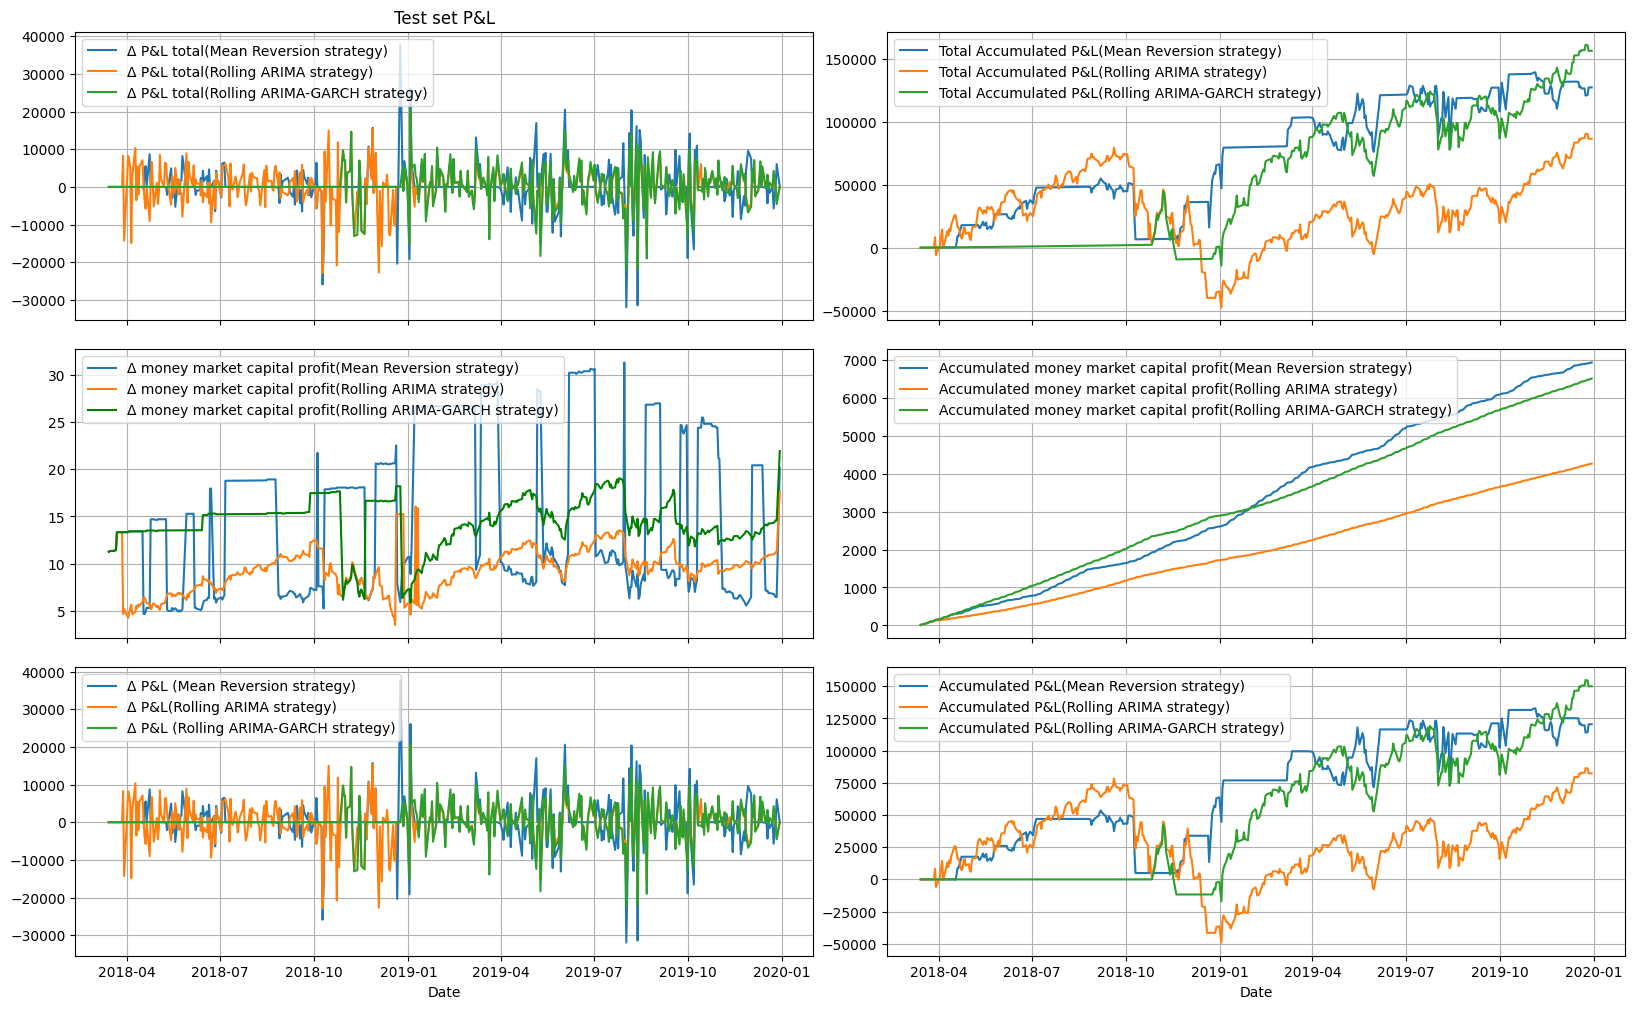

In [1582]:
fig, ((ax0,ax3),(ax1,ax4),(ax2,ax5)) = plt.subplots(3, 2, sharex=True, figsize=(20, 12))

#ax0 = plt.subplot(3,0,0)
ax0.plot(data_test['PnL'],label='\u0394 P&L total(Mean Reversion strategy)')
ax0.plot(data2_test['PnL'],label='\u0394 P&L total(Rolling ARIMA strategy)')
ax0.plot(data3_test['PnL'],label='\u0394 P&L total(Rolling ARIMA-GARCH strategy)')
ax0.legend(loc='upper left')
ax0.grid(True)
ax0.set_title('Test set P&L')

#ax1 = plt.subplot(3,1,0)
ax1.plot(data_test['capital profit'],label='\u0394 money market capital profit(Mean Reversion strategy)')
ax1.plot(data2_test['capital profit'],label='\u0394 money market capital profit(Rolling ARIMA strategy)')
ax1.plot(data3_test['capital profit'],'g-',label='\u0394 money market capital profit(Rolling ARIMA-GARCH strategy)')
ax1.legend(loc='upper left')
ax1.grid(True)

#ax2 = plt.subplot(3,2,0)
ax2.plot(data_test['PnL']-data_test['capital profit'],label='\u0394 P&L (Mean Reversion strategy)')
ax2.plot(data2_test['PnL']-data2_test['capital profit'],label='\u0394 P&L(Rolling ARIMA strategy)')
ax2.plot(data3_test['PnL']-data3_test['capital profit'],label='\u0394 P&L (Rolling ARIMA-GARCH strategy)')
ax2.legend(loc='upper left')
ax2.grid(True)
ax2.set_xlabel('Date')
ax2.set_xticklabels(ax2.get_xticklabels())

#ax3 = plt.subplot(3,0,1)
#ax3.plot(data1['PnL'].cumsum(),'r-',label='Benchmark')
ax3.plot(data_test['PnL'].cumsum(),label='Total Accumulated P&L(Mean Reversion strategy)')
ax3.plot(data2_test['PnL'].cumsum(),label='Total Accumulated P&L(Rolling ARIMA strategy)')
ax3.plot(data3_test['PnL'].cumsum(),label='Total Accumulated P&L(Rolling ARIMA-GARCH strategy)')
ax3.legend(loc='upper left')
ax3.grid(True)

#ax4 = plt.subplot(3,1,1)
ax4.plot(data_test['capital profit'].cumsum(),label='Accumulated money market capital profit(Mean Reversion strategy)')
ax4.plot(data2_test['capital profit'].cumsum(),label='Accumulated money market capital profit(Rolling ARIMA strategy)')
ax4.plot(data3_test['capital profit'].cumsum(),label='Accumulated money market capital profit(Rolling ARIMA-GARCH strategy)')
ax4.legend(loc='upper left')
ax4.grid(True)

#ax5 = plt.subplot(3,2,1)
ax5.plot((data_test['PnL']-data_test['capital profit']).cumsum(),label='Accumulated P&L(Mean Reversion strategy)')
ax5.plot((data2_test['PnL']-data2_test['capital profit']).cumsum(),label='Accumulated P&L(Rolling ARIMA strategy)')
ax5.plot((data3_test['PnL']-data3_test['capital profit']).cumsum(),label='Accumulated P&L(Rolling ARIMA-GARCH strategy)')
ax5.legend(loc='upper left')
ax5.grid(True)
ax5.set_xlabel('Date')
ax5.set_xticklabels(ax5.get_xticklabels())

plt.subplots_adjust(wspace=0.1, hspace=0.1)
#savefig
plt.savefig('P&L_test.pdf',dpi=800)
plt.show()

sahrpe ratio

In [1718]:
(data_train['PnL']-data_train['capital profit']).mean()/(data_train['PnL']-data_train['capital profit']).std() * (252**0.5)
(data_test['PnL']-data_test['capital profit']).mean()/(data_test['PnL']-data_test['capital profit']).std() * (252**0.5)


0.7691027835472992

In [1721]:
(data2_train['PnL']-data2_train['capital profit']).mean()/(data2_train['PnL']-data2_train['capital profit']).std() * 252**0.5
(data2_test['PnL']-data2_test['capital profit']).mean()/(data2_test['PnL']-data2_test['capital profit']).std() * 252**0.5

0.5405531893290788

In [1723]:
(data3_train['PnL']-data3_train['capital profit']).mean()/(data3_train['PnL']-data3_train['capital profit']).std() * 252**0.5
(data3_test['PnL']-data3_test['capital profit']).mean()/(data3_test['PnL']-data3_test['capital profit']).std() * 252**0.5

1.159082977787559

Sortino ratio

In [1729]:
(data_train['PnL']-data_train['capital profit']).mean()/((data_train['PnL']-data_train['capital profit']).apply(lambda x: x**2).sum()/(len(data_train)-1))**0.5 *252**0.5
(data_test['PnL']-data_test['capital profit']).mean()/((data_test['PnL']-data_test['capital profit']).apply(lambda x: x**2).sum()/(len(data_test)-1))**0.5 *252**0.5
(data2_train['PnL']-data2_train['capital profit']).mean()/((data2_train['PnL']-data2_train['capital profit']).apply(lambda x: x**2).sum()/(len(data2_train)-1))**0.5 *252**0.5
(data2_test['PnL']-data2_test['capital profit']).mean()/((data2_test['PnL']-data2_test['capital profit']).apply(lambda x: x**2).sum()/(len(data2_test)-1))**0.5 *252**0.5
(data3_train['PnL']-data3_train['capital profit']).mean()/((data3_train['PnL']-data3_train['capital profit']).apply(lambda x: x**2).sum()/(len(data3_train)-1))**0.5 *252**0.5
(data3_test['PnL']-data3_test['capital profit']).mean()/((data3_test['PnL']-data3_test['capital profit']).apply(lambda x: x**2).sum()/(len(data3_test)-1))**0.5 *252**0.5

1.155998819048115

MaximumDrawdown

In [1633]:
def _force(arr):
    max_withdraw = float('-inf')    # 负无穷
    n = len(arr)

    for i in range(n):
        for j in range(i+1, n):
            diff = arr[i] - arr[j]
            max_withdraw = max(max_withdraw, diff)

    return max_withdraw

In [1650]:
def get_max_drawdown_slow(array):
    drawdowns = []
    maxs = []
    for i in range(len(array)):
        max_array = max(array[:i+1])
        drawdown = max_array - array[i]
        drawdowns.append(drawdown)
        maxs.append(max_array)
    maxs[drawdowns.index(max(drawdowns))]
    return -max(drawdowns), maxs[drawdowns.index(max(drawdowns))] , -max(drawdowns)/maxs[drawdowns.index(max(drawdowns))]

In [1775]:
get_max_drawdown_slow((data_train['PnL']-data_train['capital profit']).cumsum())

(-124993.19060030924, 200323.42863271755, -0.623956925325383)

In [1776]:
get_max_drawdown_slow((data_test['PnL']-data_test['capital profit']).cumsum())

(-50926.055484304576, 53533.17051431629, -0.9512990729866355)

In [1652]:
get_max_drawdown_slow((data2_train['PnL']-data2_train['capital profit']).cumsum())

(-100795.39877113569, 56416.999055855056, -1.7866139719935168)

In [1653]:
get_max_drawdown_slow((data2_test['PnL']-data2_test['capital profit']).cumsum())

(-127483.34706803117, 78382.59304596743, -1.626424211218282)

In [1654]:
get_max_drawdown_slow((data3_train['PnL']-data3_train['capital profit']).cumsum())

(-83254.2843958035, 220991.9331572074, -0.376729970213794)

In [1655]:
get_max_drawdown_slow((data3_test['PnL']-data3_test['capital profit']).cumsum())

(-59316.3340301579, 42325.60738815917, -1.4014290093035258)

calmar ratio

In [1663]:
(data3_train['PnL']-data3_train['capital profit']).mean() * 252 / get_max_drawdown_slow((data3_train['PnL']-data3_train['capital profit']).cumsum())[2]

-121249.38875826771

In [1662]:
(data3_test['PnL']-data3_test['capital profit']).mean() * 252 / get_max_drawdown_slow((data3_test['PnL']-data3_test['capital profit']).cumsum())[2]

-59545.59775384608

In [1666]:
(data2_train['PnL']-data2_train['capital profit']).mean() * 252 / get_max_drawdown_slow((data2_train['PnL']-data2_train['capital profit']).cumsum())[2]

-31092.110772410066

In [1668]:
(data2_test['PnL']-data2_test['capital profit']).mean() * 252 / get_max_drawdown_slow((data2_test['PnL']-data2_test['capital profit']).cumsum())[2]

-28175.195344372318

In [1673]:
(data_train['PnL']-data_train['capital profit']).mean() * 252 / get_max_drawdown_slow((data_train['PnL']-data_train['capital profit']).cumsum())[2]

-56241.09410235029

In [1674]:
(data_test['PnL']-data_test['capital profit']).mean() * 252 / get_max_drawdown_slow((data_test['PnL']-data_test['capital profit']).cumsum())[2]

-70447.92733876762

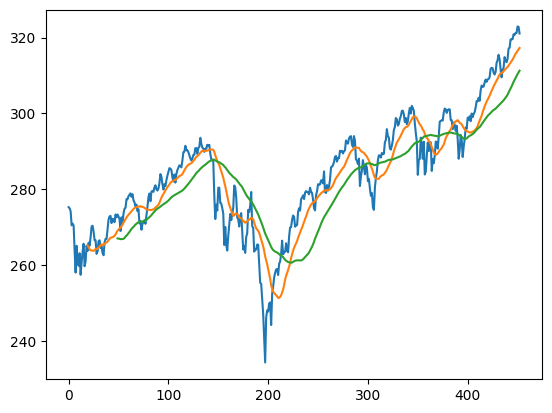

In [126]:
plt.plot(data2_test['Close'].values)
plt.plot(data2_test['Close'].rolling(window=20).mean().values)
plt.plot(data2_test['Close'].rolling(window=50).mean().values)

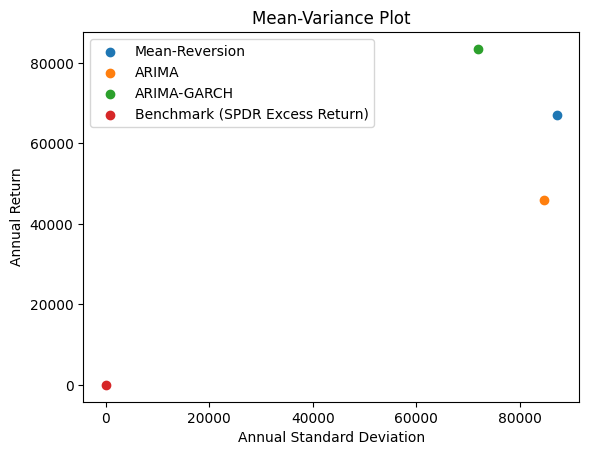

In [1742]:
plt.scatter((data_test['PnL']-data_test['capital profit']).std()*252**0.5,(data_test['PnL']-data_test['capital profit']).mean()*252,label='Mean-Reversion')
plt.scatter((data2_test['PnL']-data2_test['capital profit']).std()*252**0.5,(data2_test['PnL']-data2_test['capital profit']).mean()*252,label='ARIMA')
plt.scatter((data3_test['PnL']-data3_test['capital profit']).std()*252**0.5,(data3_test['PnL']-data3_test['capital profit']).mean()*252,label='ARIMA-GARCH')
plt.scatter(test_set['Excess return'].std(),test_set['Excess return'].mean()*252**0.5,label='Benchmark (SPDR Excess Return)')
plt.xlabel('Annual Standard Deviation')
plt.ylabel('Annual Return')
plt.title('Mean-Variance Plot')
plt.legend()
plt.savefig('Mean-Variance Plot.png')
plt.show()  

In [1730]:
a = data2_test['PnL']-data2_test['capital profit']
b = data_test['PnL']-data_test['capital profit']

(0.6*a + 0.4*b).mean()*252**0.5/(0.6*a + 0.4*b).std()

0.7724685169755758

Drawdown chart

In [1790]:
def get_max_drawdown_chart(array):
    drawdowns = pd.Series(np.zeros(len(array)),index=array.index)
    for i in range(len(array)):
        max_array = max(array[:i+1])
        drawdown = max_array - array[i]
        drawdowns[i] = drawdown
    plt.plot(drawdowns)
    return drawdowns

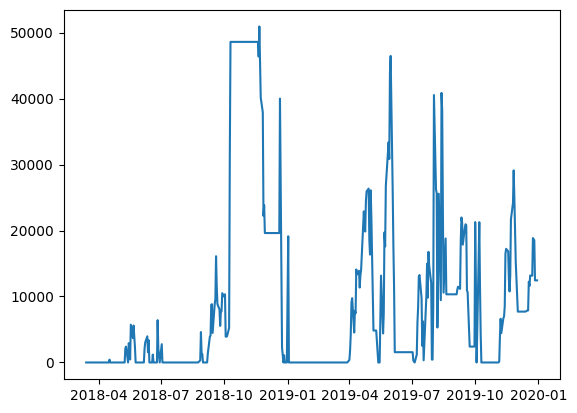

In [1818]:
a = get_max_drawdown_chart((data_test['PnL']-data_test['capital profit']).cumsum())


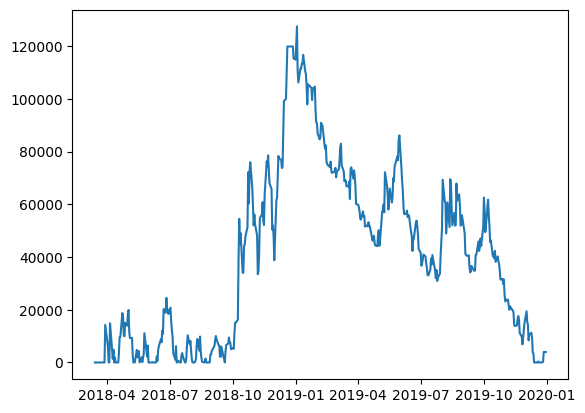

In [1792]:
b = get_max_drawdown_chart((data2_test['PnL']-data2_test['capital profit']).cumsum())

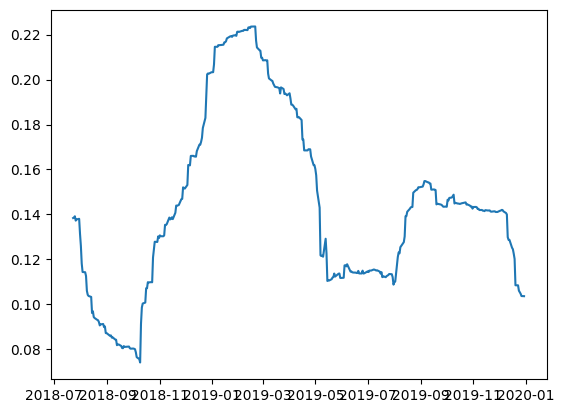

In [1793]:
plt.plot(data2_test['Close'].pct_change().rolling(90).std()*(252**0.5))

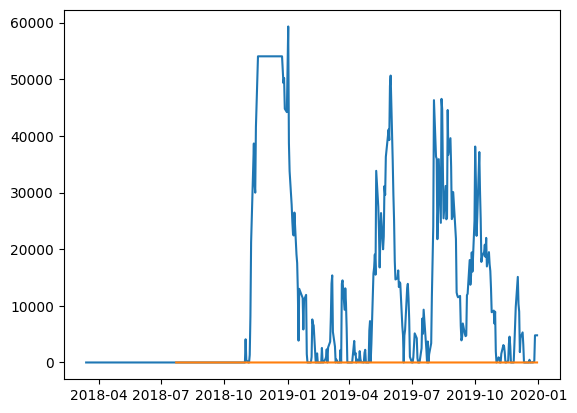

In [1794]:
c = get_max_drawdown_chart((data3_test['PnL']-data3_test['capital profit']).cumsum())
plt.plot(data3_test['Close'].pct_change().rolling(90).std()*(252**0.5))

c:\Users\47965\miniconda3\envs\pytorch\lib\site-packages\IPython\core\displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


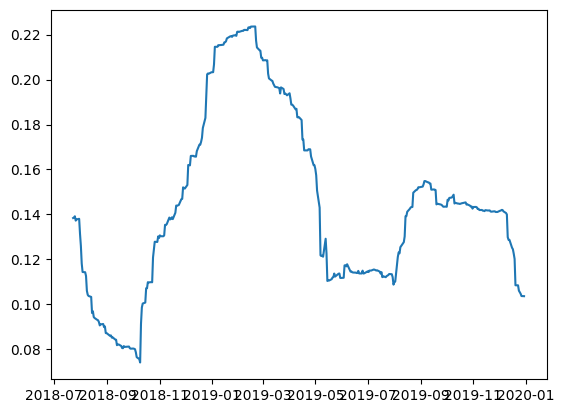

In [1795]:
plt.plot(data3_test['Close'].pct_change().rolling(90).std()*(252**0.5))

C:\Users\47965\AppData\Local\Temp\ipykernel_24796\1842130721.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels( ax1.get_xticklabels(),rotation=30)
C:\Users\47965\AppData\Local\Temp\ipykernel_24796\1842130721.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels( ax3.get_xticklabels(),rotation=30)
C:\Users\47965\AppData\Local\Temp\ipykernel_24796\1842130721.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5.set_xticklabels( ax5.get_xticklabels(),rotation=30)


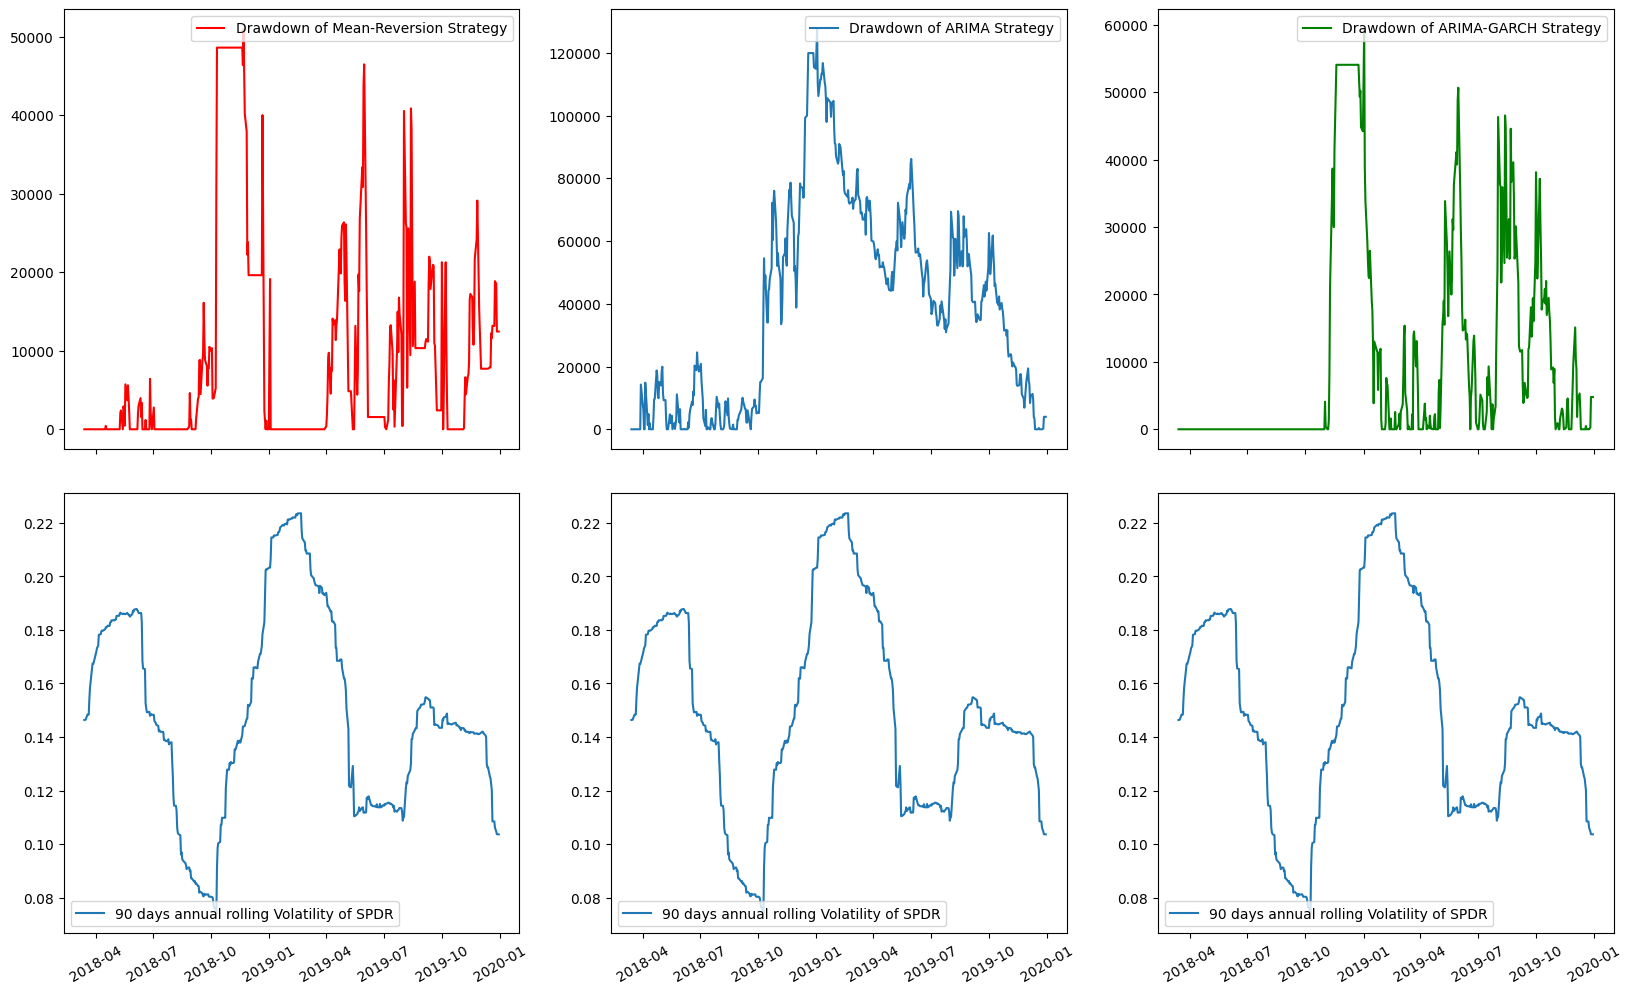

In [1819]:
fig, ((ax0,ax2,ax4),(ax1,ax3,ax5)) = plt.subplots(2, 3, sharex=True, figsize=(20, 12))
ax0.plot(a, 'r', label='Drawdown of Mean-Reversion Strategy') 
ax0.legend()
ax1.plot(assets['Close'][len(data_train)-90:].pct_change().rolling(90).std()*(252**0.5),label='90 days annual rolling Volatility of SPDR')
ax1.legend()
ax1.set_xticklabels( ax1.get_xticklabels(),rotation=30)
ax2.plot(b, label='Drawdown of ARIMA Strategy')
ax2.legend()
ax3.plot(assets['Close'][len(data_train)-90:].pct_change().rolling(90).std()*(252**0.5), label='90 days annual rolling Volatility of SPDR')
ax3.legend()
ax3.set_xticklabels( ax3.get_xticklabels(),rotation=30)
ax4.plot(c,'g', label='Drawdown of ARIMA-GARCH Strategy')
ax4.legend()
ax5.plot(assets['Close'][len(data_train)-90:].pct_change().rolling(90).std()*(252**0.5), label='90 days annual rolling Volatility of SPDR')
ax5.legend()
ax5.set_xticklabels( ax5.get_xticklabels(),rotation=30)
plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.savefig('Drawdowns.png')
plt.show()